<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [SYNOP2] - First predictions at 3h
<!-- DESC --> Episode 2 : Learning session and weather prediction attempt at 3h
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Make a simple prediction (3h)
 - Understanding the use of a recurrent neural network


SYNOP meteorological data, available at: https://public.opendatasoft.com

## What we're going to do :

 - Read our dataset
 - Select our data and normalize it
 - Doing our training
 - Making simple predictions

## Step 1 - Import and init
### 1.1 - Python

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import math, random
import matplotlib.pyplot as plt

import pandas as pd
import h5py, json
import os,time,sys

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('SYNOP2')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.12
Notebook id          : SYNOP2
Run time             : Tuesday 09 February 2021, 19:53:43
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


### 1.2 - Parameters

In [2]:
# ---- About dataset
#
dataset_dir      = './data'
dataset_filename = 'synop-LYS.csv'
schema_filename  = 'synop.json'
features         = ['tend', 'cod_tend', 'dd', 'ff', 'td', 'u', 'ww', 'pres', 'rafper', 'rr1', 'rr3', 'tc']
features_len     = len(features)

# ---- About training
#
scale            = 1        # Percentage of dataset to be used (1=all)
train_prop       = .8       # Percentage for train (the rest being for the test)
sequence_len     = 16
batch_size       = 32
epochs           = 10

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('scale', 'train_prop', 'sequence_len', 'batch_size', 'epochs')

**\*\* Overrided parameters : \*\***

scale                : 1
train_prop           : 0.8
sequence_len         : 16
batch_size           : 32
epochs               : 10


## Step 2 - Read and prepare dataset
### 2.1 - Read it

In [4]:
# ---- Read dataset from ./data

df = pd.read_csv(f'{dataset_dir}/{dataset_filename}', header=0, sep=';')

# ---- Scaling

df = df[:int(scale*len(df))]
train_len=int(train_prop*len(df))

# ---- Train / Test
dataset_train = df.loc[ :train_len-1, features ]
dataset_test  = df.loc[train_len:,    features ]
pwk.subtitle('Train dataset example :')
display(dataset_train.head(15))

# ---- Normalize, and convert to numpy array

mean = dataset_train.mean()
std  = dataset_train.std()
dataset_train = (dataset_train - mean) / std
dataset_test  = (dataset_test  - mean) / std

pwk.subtitle('After normalization :')
display(dataset_train.describe().style.format("{0:.2f}"))

dataset_train = dataset_train.to_numpy()
dataset_test  = dataset_test.to_numpy()

pwk.subtitle('Shapes :')
print('Dataset       : ',df.shape)
print('Train dataset : ',dataset_train.shape)
print('Test  dataset : ',dataset_test.shape)


<br>**Train dataset example :**

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
0,-120.0,6.0,0.0,0.0,278.75,88.0,60.0,96250.0,4.1,0.0,0.0,7.5
1,-150.0,6.0,60.0,1.0,278.65,93.0,61.0,96100.0,2.6,0.2,0.6,6.6
2,10.0,3.0,280.0,2.1,278.85,95.0,58.0,96110.0,2.6,0.0,0.4,6.4
3,230.0,3.0,310.0,2.6,279.15,96.0,50.0,96340.0,5.7,0.0,3.0,6.6
4,280.0,1.0,330.0,4.6,278.15,94.0,21.0,96620.0,8.7,0.4,0.8,5.9
5,480.0,3.0,350.0,5.1,276.95,91.0,60.0,97100.0,8.2,0.2,0.4,5.2
6,530.0,2.0,350.0,3.1,274.05,83.0,21.0,97630.0,7.2,0.0,0.0,3.5
7,450.0,2.0,340.0,6.2,272.15,81.0,2.0,98080.0,9.3,0.0,0.0,1.9
8,280.0,1.0,320.0,6.2,270.15,74.0,2.0,98360.0,10.3,0.0,0.0,1.1
9,220.0,1.0,290.0,2.6,269.65,72.0,2.0,98580.0,5.1,0.0,0.0,1.0


<br>**After normalization :**

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
count,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00
mean,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-6.79,-1.59,-1.74,-1.36,-5.22,-3.85,-0.53,-4.97,-1.62,-0.32,-0.27,-3.04
25%,-0.63,-0.85,-0.62,-0.75,-0.72,-0.68,-0.42,-0.55,-0.69,-0.16,-0.20,-0.75
50%,-0.00,-0.48,-0.11,-0.19,0.04,0.21,-0.42,0.04,-0.29,-0.16,-0.20,-0.01
75%,0.63,0.99,1.10,0.50,0.77,0.82,-0.37,0.62,0.51,-0.16,-0.20,0.71
max,7.14,1.36,1.35,6.24,2.44,1.59,4.45,3.08,6.25,29.82,31.17,3.07


<br>**Shapes :**

Dataset       :  (29165, 14)
Train dataset :  (23332, 12)
Test  dataset :  (5833, 12)


### 2.2 - Prepare data generator

In [5]:
# ---- Train generator
train_generator = TimeseriesGenerator(dataset_train, dataset_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(dataset_test,  dataset_test,  length=sequence_len,  batch_size=batch_size)

# ---- About

pwk.subtitle('About the splitting of our dataset :')

x,y=train_generator[0]
print(f'Nombre de train batchs disponibles : ', len(train_generator))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

x,y=train_generator[0]
pwk.subtitle('What a batch looks like (x) :')
pwk.np_print(x[0] )
pwk.subtitle('What a batch looks like (y) :')
pwk.np_print(y[0])

<br>**About the splitting of our dataset :**

Nombre de train batchs disponibles :  729
batch x shape :  (32, 16, 12)
batch y shape :  (32, 12)


<br>**What a batch looks like (x) :**

[[-1.087  0.623 -1.743 -1.361 -0.212  0.928  2.554 -3.533 -0.555 -0.156 -0.199 -0.624]
 [-1.358  0.623 -1.227 -0.957 -0.229  1.206  2.605 -3.733 -0.946  0.17   0.219 -0.735]
 [ 0.089 -0.482  0.666 -0.512 -0.195  1.317  2.451 -3.72  -0.946 -0.156  0.08  -0.76 ]
 [ 2.079 -0.482  0.924 -0.31  -0.144  1.372  2.04  -3.413 -0.137 -0.156  1.892 -0.735]
 [ 2.531 -1.219  1.096  0.499 -0.313  1.261  0.552 -3.04   0.645  0.495  0.358 -0.821]
 [ 4.34  -0.482  1.268  0.701 -0.517  1.095  2.554 -2.401  0.515  0.17   0.08  -0.907]
 [ 4.792 -0.85   1.268 -0.107 -1.01   0.65   0.552 -1.694  0.254 -0.156 -0.199 -1.117]
 [ 4.069 -0.85   1.182  1.146 -1.333  0.539 -0.424 -1.094  0.802 -0.156 -0.199 -1.314]
 [ 2.531 -1.219  1.01   1.146 -1.673  0.15  -0.424 -0.721  1.063 -0.156 -0.199 -1.412]
 [ 1.988 -1.219  0.752 -0.31  -1.758  0.039 -0.424 -0.428 -0.294 -0.156 -0.199 -1.425]
 [ 0.903 -1.219  1.268 -0.107 -1.622  0.428 -0.424 -0.295 -0.555 -0.156 -0.199 -1.486]
 [ 2.712 -0.482  1.268  0.701 -1.944 -0.072

<br>**What a batch looks like (y) :**

[ 0.179 -1.219  0.58  -0.755 -2.063  0.65  -0.424  0.665 -1.233 -0.156 -0.199 -1.93 ]


## Step 3 - Create a model

In [6]:
model = keras.models.Sequential()
model.add( keras.layers.InputLayer(input_shape=(sequence_len, features_len)) )
model.add( keras.layers.LSTM(100, activation='relu') )
model.add( keras.layers.Dropout(0.2) )
model.add( keras.layers.Dense(features_len) )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               45200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 12)                1212      
Total params: 46,412
Trainable params: 46,412
Non-trainable params: 0
_________________________________________________________________


# Step 4 - Compile and run

### 4.1 - Callback

In [7]:
pwk.mkdir('./run/models')
save_dir = './run/models/best_model.h5'
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 4.2 - Compile

In [8]:
model.compile(optimizer='adam', 
              loss='mse', 
              metrics   = ['mae'] )

### 4.3 - Fit
6' with a CPU (laptop)  
2' with a GPU

In [9]:
pwk.chrono_start()

history=model.fit(train_generator, 
                  epochs=epochs, 
                  verbose=1,
                  validation_data = test_generator,
                  callbacks = [bestmodel_callback])

pwk.chrono_show()

Epoch 1/10


  1/729 [..............................] - ETA: 26:50 - loss: 1.0804 - mae: 0.8138

  4/729 [..............................] - ETA: 12s - loss: 1.3347 - mae: 0.8199  

  7/729 [..............................] - ETA: 12s - loss: 1.2516 - mae: 0.7888

 10/729 [..............................] - ETA: 12s - loss: 1.1748 - mae: 0.7667

 13/729 [..............................] - ETA: 12s - loss: 1.1151 - mae: 0.7505

 16/729 [..............................] - ETA: 12s - loss: 1.0774 - mae: 0.7404

 20/729 [..............................] - ETA: 12s - loss: 1.0417 - mae: 0.7312

 23/729 [..............................] - ETA: 12s - loss: 1.0213 - mae: 0.7261

 26/729 [>.............................] - ETA: 12s - loss: 1.0040 - mae: 0.7210

 30/729 [>.............................] - ETA: 12s - loss: 0.9869 - mae: 0.7158

 33/729 [>.............................] - ETA: 12s - loss: 0.9747 - mae: 0.7122

 36/729 [>.............................] - ETA: 12s - loss: 0.9623 - mae: 0.7083

 39/729 [>.............................] - ETA: 12s - loss: 0.9501 - mae: 0.7044

 42/729 [>.............................] - ETA: 11s - loss: 0.9389 - mae: 0.7006

 45/729 [>.............................] - ETA: 11s - loss: 0.9299 - mae: 0.6971

 48/729 [>.............................] - ETA: 11s - loss: 0.9211 - mae: 0.6936

 52/729 [=>............................] - ETA: 11s - loss: 0.9156 - mae: 0.6896

 55/729 [=>............................] - ETA: 11s - loss: 0.9110 - mae: 0.6866

 59/729 [=>............................] - ETA: 11s - loss: 0.9053 - mae: 0.6829

 62/729 [=>............................] - ETA: 11s - loss: 0.9008 - mae: 0.6803

 65/729 [=>............................] - ETA: 11s - loss: 0.8965 - mae: 0.6779

 68/729 [=>............................] - ETA: 11s - loss: 0.8929 - mae: 0.6758

 71/729 [=>............................] - ETA: 11s - loss: 0.8892 - mae: 0.6738

 74/729 [==>...........................] - ETA: 11s - loss: 0.8853 - mae: 0.6717

 77/729 [==>...........................] - ETA: 11s - loss: 0.8814 - mae: 0.6698

 80/729 [==>...........................] - ETA: 11s - loss: 0.8777 - mae: 0.6679

 83/729 [==>...........................] - ETA: 11s - loss: 0.8738 - mae: 0.6660

 86/729 [==>...........................] - ETA: 11s - loss: 0.8700 - mae: 0.6642

 89/729 [==>...........................] - ETA: 11s - loss: 0.8665 - mae: 0.6624

 92/729 [==>...........................] - ETA: 11s - loss: 0.8631 - mae: 0.6607

 96/729 [==>...........................] - ETA: 11s - loss: 0.8587 - mae: 0.6586

100/729 [===>..........................] - ETA: 10s - loss: 0.8545 - mae: 0.6565

104/729 [===>..........................] - ETA: 10s - loss: 0.8502 - mae: 0.6545

108/729 [===>..........................] - ETA: 10s - loss: 0.8461 - mae: 0.6526

112/729 [===>..........................] - ETA: 10s - loss: 0.8420 - mae: 0.6508

116/729 [===>..........................] - ETA: 10s - loss: 0.8381 - mae: 0.6490

120/729 [===>..........................] - ETA: 10s - loss: 0.8342 - mae: 0.6473

124/729 [====>.........................] - ETA: 10s - loss: 0.8305 - mae: 0.6457

128/729 [====>.........................] - ETA: 10s - loss: 0.8268 - mae: 0.6441

132/729 [====>.........................] - ETA: 9s - loss: 0.8232 - mae: 0.6425 

136/729 [====>.........................] - ETA: 9s - loss: 0.8197 - mae: 0.6409

140/729 [====>.........................] - ETA: 9s - loss: 0.8162 - mae: 0.6394

144/729 [====>.........................] - ETA: 9s - loss: 0.8129 - mae: 0.6379

148/729 [=====>........................] - ETA: 9s - loss: 0.8098 - mae: 0.6365

152/729 [=====>........................] - ETA: 9s - loss: 0.8067 - mae: 0.6351

156/729 [=====>........................] - ETA: 9s - loss: 0.8039 - mae: 0.6338

160/729 [=====>........................] - ETA: 9s - loss: 0.8012 - mae: 0.6326

164/729 [=====>........................] - ETA: 9s - loss: 0.7986 - mae: 0.6314

168/729 [=====>........................] - ETA: 9s - loss: 0.7960 - mae: 0.6302

172/729 [======>.......................] - ETA: 9s - loss: 0.7934 - mae: 0.6290

176/729 [======>.......................] - ETA: 8s - loss: 0.7910 - mae: 0.6279

180/729 [======>.......................] - ETA: 8s - loss: 0.7889 - mae: 0.6268

184/729 [======>.......................] - ETA: 8s - loss: 0.7869 - mae: 0.6258

188/729 [======>.......................] - ETA: 8s - loss: 0.7848 - mae: 0.6248

192/729 [======>.......................] - ETA: 8s - loss: 0.7828 - mae: 0.6238

196/729 [=======>......................] - ETA: 8s - loss: 0.7808 - mae: 0.6228

200/729 [=======>......................] - ETA: 8s - loss: 0.7790 - mae: 0.6218

204/729 [=======>......................] - ETA: 8s - loss: 0.7772 - mae: 0.6209

208/729 [=======>......................] - ETA: 8s - loss: 0.7754 - mae: 0.6199

212/729 [=======>......................] - ETA: 8s - loss: 0.7736 - mae: 0.6190

216/729 [=======>......................] - ETA: 8s - loss: 0.7719 - mae: 0.6181

220/729 [========>.....................] - ETA: 8s - loss: 0.7701 - mae: 0.6172

224/729 [========>.....................] - ETA: 8s - loss: 0.7683 - mae: 0.6163

228/729 [========>.....................] - ETA: 7s - loss: 0.7665 - mae: 0.6154

232/729 [========>.....................] - ETA: 7s - loss: 0.7647 - mae: 0.6145

236/729 [========>.....................] - ETA: 7s - loss: 0.7630 - mae: 0.6136

240/729 [========>.....................] - ETA: 7s - loss: 0.7612 - mae: 0.6128

244/729 [=========>....................] - ETA: 7s - loss: 0.7596 - mae: 0.6119

248/729 [=========>....................] - ETA: 7s - loss: 0.7580 - mae: 0.6110

252/729 [=========>....................] - ETA: 7s - loss: 0.7564 - mae: 0.6102

256/729 [=========>....................] - ETA: 7s - loss: 0.7548 - mae: 0.6094

260/729 [=========>....................] - ETA: 7s - loss: 0.7532 - mae: 0.6086

264/729 [=========>....................] - ETA: 7s - loss: 0.7517 - mae: 0.6078

268/729 [==========>...................] - ETA: 7s - loss: 0.7501 - mae: 0.6070

272/729 [==========>...................] - ETA: 7s - loss: 0.7486 - mae: 0.6062

276/729 [==========>...................] - ETA: 7s - loss: 0.7471 - mae: 0.6054

280/729 [==========>...................] - ETA: 7s - loss: 0.7456 - mae: 0.6046

284/729 [==========>...................] - ETA: 6s - loss: 0.7441 - mae: 0.6039

288/729 [==========>...................] - ETA: 6s - loss: 0.7428 - mae: 0.6031

292/729 [===========>..................] - ETA: 6s - loss: 0.7416 - mae: 0.6024

296/729 [===========>..................] - ETA: 6s - loss: 0.7404 - mae: 0.6017

300/729 [===========>..................] - ETA: 6s - loss: 0.7392 - mae: 0.6010

304/729 [===========>..................] - ETA: 6s - loss: 0.7380 - mae: 0.6003

308/729 [===========>..................] - ETA: 6s - loss: 0.7369 - mae: 0.5996

312/729 [===========>..................] - ETA: 6s - loss: 0.7358 - mae: 0.5989

316/729 [============>.................] - ETA: 6s - loss: 0.7348 - mae: 0.5983

320/729 [============>.................] - ETA: 6s - loss: 0.7339 - mae: 0.5977

324/729 [============>.................] - ETA: 6s - loss: 0.7330 - mae: 0.5970

328/729 [============>.................] - ETA: 6s - loss: 0.7321 - mae: 0.5964

332/729 [============>.................] - ETA: 6s - loss: 0.7312 - mae: 0.5958

336/729 [============>.................] - ETA: 6s - loss: 0.7303 - mae: 0.5952

339/729 [============>.................] - ETA: 6s - loss: 0.7296 - mae: 0.5947

342/729 [=============>................] - ETA: 6s - loss: 0.7289 - mae: 0.5943

345/729 [=============>................] - ETA: 5s - loss: 0.7282 - mae: 0.5938

348/729 [=============>................] - ETA: 5s - loss: 0.7276 - mae: 0.5934

351/729 [=============>................] - ETA: 5s - loss: 0.7270 - mae: 0.5930

354/729 [=============>................] - ETA: 5s - loss: 0.7263 - mae: 0.5925

357/729 [=============>................] - ETA: 5s - loss: 0.7257 - mae: 0.5921

360/729 [=============>................] - ETA: 5s - loss: 0.7251 - mae: 0.5917

364/729 [=============>................] - ETA: 5s - loss: 0.7243 - mae: 0.5912

367/729 [==============>...............] - ETA: 5s - loss: 0.7238 - mae: 0.5908

370/729 [==============>...............] - ETA: 5s - loss: 0.7233 - mae: 0.5904

373/729 [==============>...............] - ETA: 5s - loss: 0.7227 - mae: 0.5900

376/729 [==============>...............] - ETA: 5s - loss: 0.7222 - mae: 0.5896

379/729 [==============>...............] - ETA: 5s - loss: 0.7217 - mae: 0.5892

382/729 [==============>...............] - ETA: 5s - loss: 0.7212 - mae: 0.5888

386/729 [==============>...............] - ETA: 5s - loss: 0.7205 - mae: 0.5883

390/729 [===============>..............] - ETA: 5s - loss: 0.7198 - mae: 0.5878

393/729 [===============>..............] - ETA: 5s - loss: 0.7193 - mae: 0.5875

396/729 [===============>..............] - ETA: 5s - loss: 0.7188 - mae: 0.5871

399/729 [===============>..............] - ETA: 5s - loss: 0.7183 - mae: 0.5868

402/729 [===============>..............] - ETA: 5s - loss: 0.7178 - mae: 0.5864

405/729 [===============>..............] - ETA: 5s - loss: 0.7173 - mae: 0.5861

408/729 [===============>..............] - ETA: 5s - loss: 0.7168 - mae: 0.5857

411/729 [===============>..............] - ETA: 5s - loss: 0.7163 - mae: 0.5854

415/729 [================>.............] - ETA: 4s - loss: 0.7157 - mae: 0.5849

419/729 [================>.............] - ETA: 4s - loss: 0.7150 - mae: 0.5845

423/729 [================>.............] - ETA: 4s - loss: 0.7144 - mae: 0.5840

427/729 [================>.............] - ETA: 4s - loss: 0.7138 - mae: 0.5836

431/729 [================>.............] - ETA: 4s - loss: 0.7131 - mae: 0.5831

435/729 [================>.............] - ETA: 4s - loss: 0.7125 - mae: 0.5827

439/729 [=================>............] - ETA: 4s - loss: 0.7119 - mae: 0.5823

443/729 [=================>............] - ETA: 4s - loss: 0.7114 - mae: 0.5818

447/729 [=================>............] - ETA: 4s - loss: 0.7108 - mae: 0.5814

451/729 [=================>............] - ETA: 4s - loss: 0.7103 - mae: 0.5810

455/729 [=================>............] - ETA: 4s - loss: 0.7097 - mae: 0.5806

459/729 [=================>............] - ETA: 4s - loss: 0.7092 - mae: 0.5802

463/729 [==================>...........] - ETA: 4s - loss: 0.7087 - mae: 0.5798

467/729 [==================>...........] - ETA: 4s - loss: 0.7082 - mae: 0.5794

471/729 [==================>...........] - ETA: 4s - loss: 0.7077 - mae: 0.5790

475/729 [==================>...........] - ETA: 4s - loss: 0.7071 - mae: 0.5787

479/729 [==================>...........] - ETA: 3s - loss: 0.7066 - mae: 0.5783

483/729 [==================>...........] - ETA: 3s - loss: 0.7060 - mae: 0.5779

487/729 [===================>..........] - ETA: 3s - loss: 0.7055 - mae: 0.5775

491/729 [===================>..........] - ETA: 3s - loss: 0.7050 - mae: 0.5771

495/729 [===================>..........] - ETA: 3s - loss: 0.7045 - mae: 0.5767

499/729 [===================>..........] - ETA: 3s - loss: 0.7041 - mae: 0.5764

503/729 [===================>..........] - ETA: 3s - loss: 0.7036 - mae: 0.5760

507/729 [===================>..........] - ETA: 3s - loss: 0.7032 - mae: 0.5756

511/729 [====================>.........] - ETA: 3s - loss: 0.7027 - mae: 0.5753

515/729 [====================>.........] - ETA: 3s - loss: 0.7022 - mae: 0.5749

519/729 [====================>.........] - ETA: 3s - loss: 0.7018 - mae: 0.5745

523/729 [====================>.........] - ETA: 3s - loss: 0.7013 - mae: 0.5742

527/729 [====================>.........] - ETA: 3s - loss: 0.7008 - mae: 0.5738

531/729 [====================>.........] - ETA: 3s - loss: 0.7004 - mae: 0.5734

535/729 [=====================>........] - ETA: 3s - loss: 0.6999 - mae: 0.5731

539/729 [=====================>........] - ETA: 2s - loss: 0.6994 - mae: 0.5727

543/729 [=====================>........] - ETA: 2s - loss: 0.6989 - mae: 0.5724

547/729 [=====================>........] - ETA: 2s - loss: 0.6985 - mae: 0.5720

551/729 [=====================>........] - ETA: 2s - loss: 0.6980 - mae: 0.5717

555/729 [=====================>........] - ETA: 2s - loss: 0.6975 - mae: 0.5713

559/729 [======================>.......] - ETA: 2s - loss: 0.6971 - mae: 0.5710

563/729 [======================>.......] - ETA: 2s - loss: 0.6966 - mae: 0.5707

567/729 [======================>.......] - ETA: 2s - loss: 0.6961 - mae: 0.5703

571/729 [======================>.......] - ETA: 2s - loss: 0.6956 - mae: 0.5700

575/729 [======================>.......] - ETA: 2s - loss: 0.6951 - mae: 0.5697

579/729 [======================>.......] - ETA: 2s - loss: 0.6946 - mae: 0.5693

583/729 [======================>.......] - ETA: 2s - loss: 0.6941 - mae: 0.5690

587/729 [=======================>......] - ETA: 2s - loss: 0.6937 - mae: 0.5686

591/729 [=======================>......] - ETA: 2s - loss: 0.6932 - mae: 0.5683

595/729 [=======================>......] - ETA: 2s - loss: 0.6927 - mae: 0.5680

599/729 [=======================>......] - ETA: 2s - loss: 0.6922 - mae: 0.5677

603/729 [=======================>......] - ETA: 1s - loss: 0.6918 - mae: 0.5673

607/729 [=======================>......] - ETA: 1s - loss: 0.6913 - mae: 0.5670

611/729 [========================>.....] - ETA: 1s - loss: 0.6908 - mae: 0.5667

615/729 [========================>.....] - ETA: 1s - loss: 0.6903 - mae: 0.5664

619/729 [========================>.....] - ETA: 1s - loss: 0.6898 - mae: 0.5660

623/729 [========================>.....] - ETA: 1s - loss: 0.6893 - mae: 0.5657

627/729 [========================>.....] - ETA: 1s - loss: 0.6888 - mae: 0.5654

631/729 [========================>.....] - ETA: 1s - loss: 0.6883 - mae: 0.5651

635/729 [=========================>....] - ETA: 1s - loss: 0.6878 - mae: 0.5648

639/729 [=========================>....] - ETA: 1s - loss: 0.6873 - mae: 0.5644

643/729 [=========================>....] - ETA: 1s - loss: 0.6869 - mae: 0.5641

647/729 [=========================>....] - ETA: 1s - loss: 0.6864 - mae: 0.5638

651/729 [=========================>....] - ETA: 1s - loss: 0.6859 - mae: 0.5635

655/729 [=========================>....] - ETA: 1s - loss: 0.6855 - mae: 0.5632

659/729 [==========================>...] - ETA: 1s - loss: 0.6850 - mae: 0.5629

663/729 [==========================>...] - ETA: 1s - loss: 0.6846 - mae: 0.5626

667/729 [==========================>...] - ETA: 0s - loss: 0.6841 - mae: 0.5623

671/729 [==========================>...] - ETA: 0s - loss: 0.6837 - mae: 0.5620

675/729 [==========================>...] - ETA: 0s - loss: 0.6832 - mae: 0.5617

679/729 [==========================>...] - ETA: 0s - loss: 0.6828 - mae: 0.5614

683/729 [===========================>..] - ETA: 0s - loss: 0.6824 - mae: 0.5611

687/729 [===========================>..] - ETA: 0s - loss: 0.6819 - mae: 0.5609

691/729 [===========================>..] - ETA: 0s - loss: 0.6815 - mae: 0.5606

695/729 [===========================>..] - ETA: 0s - loss: 0.6811 - mae: 0.5603

699/729 [===========================>..] - ETA: 0s - loss: 0.6807 - mae: 0.5600

703/729 [===========================>..] - ETA: 0s - loss: 0.6803 - mae: 0.5597

707/729 [============================>.] - ETA: 0s - loss: 0.6799 - mae: 0.5595

711/729 [============================>.] - ETA: 0s - loss: 0.6794 - mae: 0.5592

715/729 [============================>.] - ETA: 0s - loss: 0.6790 - mae: 0.5589

719/729 [============================>.] - ETA: 0s - loss: 0.6786 - mae: 0.5586

723/729 [============================>.] - ETA: 0s - loss: 0.6782 - mae: 0.5584

727/729 [============================>.] - ETA: 0s - loss: 0.6778 - mae: 0.5581

729/729 [==============================] - 15s 18ms/step - loss: 0.6775 - mae: 0.5579 - val_loss: 0.4883 - val_mae: 0.4235


Epoch 2/10
  1/729 [..............................] - ETA: 28s - loss: 0.6640 - mae: 0.4766

  4/729 [..............................] - ETA: 13s - loss: 0.5542 - mae: 0.4537

  7/729 [..............................] - ETA: 12s - loss: 0.5529 - mae: 0.4638

 11/729 [..............................] - ETA: 11s - loss: 0.5239 - mae: 0.4577

 15/729 [..............................] - ETA: 11s - loss: 0.5103 - mae: 0.4550

 19/729 [..............................] - ETA: 11s - loss: 0.5084 - mae: 0.4556

 23/729 [..............................] - ETA: 10s - loss: 0.5120 - mae: 0.4566

 27/729 [>.............................] - ETA: 10s - loss: 0.5167 - mae: 0.4580

 31/729 [>.............................] - ETA: 10s - loss: 0.5182 - mae: 0.4587

 35/729 [>.............................] - ETA: 10s - loss: 0.5230 - mae: 0.4598

 39/729 [>.............................] - ETA: 10s - loss: 0.5266 - mae: 0.4603

 43/729 [>.............................] - ETA: 10s - loss: 0.5297 - mae: 0.4604

 47/729 [>.............................] - ETA: 10s - loss: 0.5340 - mae: 0.4610

 51/729 [=>............................] - ETA: 10s - loss: 0.5430 - mae: 0.4617

 55/729 [=>............................] - ETA: 10s - loss: 0.5499 - mae: 0.4623

 59/729 [=>............................] - ETA: 10s - loss: 0.5546 - mae: 0.4625

 63/729 [=>............................] - ETA: 10s - loss: 0.5581 - mae: 0.4628

 67/729 [=>............................] - ETA: 9s - loss: 0.5603 - mae: 0.4629 

 71/729 [=>............................] - ETA: 9s - loss: 0.5617 - mae: 0.4629

 75/729 [==>...........................] - ETA: 9s - loss: 0.5623 - mae: 0.4628

 79/729 [==>...........................] - ETA: 9s - loss: 0.5625 - mae: 0.4627

 83/729 [==>...........................] - ETA: 9s - loss: 0.5623 - mae: 0.4626

 87/729 [==>...........................] - ETA: 9s - loss: 0.5618 - mae: 0.4624

 91/729 [==>...........................] - ETA: 9s - loss: 0.5611 - mae: 0.4622

 95/729 [==>...........................] - ETA: 9s - loss: 0.5603 - mae: 0.4619

 99/729 [===>..........................] - ETA: 9s - loss: 0.5596 - mae: 0.4617

103/729 [===>..........................] - ETA: 9s - loss: 0.5591 - mae: 0.4616

107/729 [===>..........................] - ETA: 9s - loss: 0.5595 - mae: 0.4615

111/729 [===>..........................] - ETA: 9s - loss: 0.5599 - mae: 0.4614

115/729 [===>..........................] - ETA: 9s - loss: 0.5607 - mae: 0.4614

119/729 [===>..........................] - ETA: 9s - loss: 0.5616 - mae: 0.4613

123/729 [====>.........................] - ETA: 9s - loss: 0.5627 - mae: 0.4613

127/729 [====>.........................] - ETA: 8s - loss: 0.5636 - mae: 0.4613

131/729 [====>.........................] - ETA: 8s - loss: 0.5642 - mae: 0.4613

135/729 [====>.........................] - ETA: 8s - loss: 0.5646 - mae: 0.4612

139/729 [====>.........................] - ETA: 8s - loss: 0.5649 - mae: 0.4611

143/729 [====>.........................] - ETA: 8s - loss: 0.5650 - mae: 0.4610

147/729 [=====>........................] - ETA: 8s - loss: 0.5650 - mae: 0.4610

151/729 [=====>........................] - ETA: 8s - loss: 0.5650 - mae: 0.4609

155/729 [=====>........................] - ETA: 8s - loss: 0.5654 - mae: 0.4608

159/729 [=====>........................] - ETA: 8s - loss: 0.5655 - mae: 0.4607

163/729 [=====>........................] - ETA: 8s - loss: 0.5655 - mae: 0.4606

167/729 [=====>........................] - ETA: 8s - loss: 0.5655 - mae: 0.4605

171/729 [======>.......................] - ETA: 8s - loss: 0.5653 - mae: 0.4603

175/729 [======>.......................] - ETA: 8s - loss: 0.5650 - mae: 0.4601

179/729 [======>.......................] - ETA: 8s - loss: 0.5647 - mae: 0.4600

183/729 [======>.......................] - ETA: 8s - loss: 0.5644 - mae: 0.4598

187/729 [======>.......................] - ETA: 8s - loss: 0.5641 - mae: 0.4596

191/729 [======>.......................] - ETA: 8s - loss: 0.5636 - mae: 0.4595

195/729 [=======>......................] - ETA: 7s - loss: 0.5632 - mae: 0.4593

199/729 [=======>......................] - ETA: 7s - loss: 0.5627 - mae: 0.4591

203/729 [=======>......................] - ETA: 7s - loss: 0.5621 - mae: 0.4589

207/729 [=======>......................] - ETA: 7s - loss: 0.5616 - mae: 0.4587

211/729 [=======>......................] - ETA: 7s - loss: 0.5611 - mae: 0.4585

215/729 [=======>......................] - ETA: 7s - loss: 0.5605 - mae: 0.4583

219/729 [========>.....................] - ETA: 7s - loss: 0.5599 - mae: 0.4581

223/729 [========>.....................] - ETA: 7s - loss: 0.5594 - mae: 0.4580

227/729 [========>.....................] - ETA: 7s - loss: 0.5589 - mae: 0.4578

231/729 [========>.....................] - ETA: 7s - loss: 0.5583 - mae: 0.4576

235/729 [========>.....................] - ETA: 7s - loss: 0.5577 - mae: 0.4575

239/729 [========>.....................] - ETA: 7s - loss: 0.5571 - mae: 0.4573

243/729 [=========>....................] - ETA: 7s - loss: 0.5564 - mae: 0.4571

247/729 [=========>....................] - ETA: 7s - loss: 0.5558 - mae: 0.4569

251/729 [=========>....................] - ETA: 7s - loss: 0.5553 - mae: 0.4568

255/729 [=========>....................] - ETA: 7s - loss: 0.5548 - mae: 0.4566

259/729 [=========>....................] - ETA: 6s - loss: 0.5543 - mae: 0.4565

263/729 [=========>....................] - ETA: 6s - loss: 0.5538 - mae: 0.4563

267/729 [=========>....................] - ETA: 6s - loss: 0.5534 - mae: 0.4562

271/729 [==========>...................] - ETA: 6s - loss: 0.5529 - mae: 0.4560

275/729 [==========>...................] - ETA: 6s - loss: 0.5525 - mae: 0.4559

279/729 [==========>...................] - ETA: 6s - loss: 0.5520 - mae: 0.4558

283/729 [==========>...................] - ETA: 6s - loss: 0.5516 - mae: 0.4556

287/729 [==========>...................] - ETA: 6s - loss: 0.5511 - mae: 0.4555

291/729 [==========>...................] - ETA: 6s - loss: 0.5506 - mae: 0.4553

295/729 [===========>..................] - ETA: 6s - loss: 0.5502 - mae: 0.4552

299/729 [===========>..................] - ETA: 6s - loss: 0.5497 - mae: 0.4550

303/729 [===========>..................] - ETA: 6s - loss: 0.5493 - mae: 0.4549

307/729 [===========>..................] - ETA: 6s - loss: 0.5489 - mae: 0.4548

311/729 [===========>..................] - ETA: 6s - loss: 0.5486 - mae: 0.4547

315/729 [===========>..................] - ETA: 6s - loss: 0.5482 - mae: 0.4546

319/729 [============>.................] - ETA: 6s - loss: 0.5479 - mae: 0.4544

323/729 [============>.................] - ETA: 6s - loss: 0.5475 - mae: 0.4543

327/729 [============>.................] - ETA: 5s - loss: 0.5472 - mae: 0.4542

331/729 [============>.................] - ETA: 5s - loss: 0.5470 - mae: 0.4541

335/729 [============>.................] - ETA: 5s - loss: 0.5467 - mae: 0.4540

339/729 [============>.................] - ETA: 5s - loss: 0.5464 - mae: 0.4539

343/729 [=============>................] - ETA: 5s - loss: 0.5462 - mae: 0.4538

347/729 [=============>................] - ETA: 5s - loss: 0.5459 - mae: 0.4537

351/729 [=============>................] - ETA: 5s - loss: 0.5457 - mae: 0.4537

355/729 [=============>................] - ETA: 5s - loss: 0.5454 - mae: 0.4536

359/729 [=============>................] - ETA: 5s - loss: 0.5452 - mae: 0.4535

363/729 [=============>................] - ETA: 5s - loss: 0.5449 - mae: 0.4534

367/729 [==============>...............] - ETA: 5s - loss: 0.5447 - mae: 0.4534

371/729 [==============>...............] - ETA: 5s - loss: 0.5445 - mae: 0.4533

375/729 [==============>...............] - ETA: 5s - loss: 0.5443 - mae: 0.4532

379/729 [==============>...............] - ETA: 5s - loss: 0.5440 - mae: 0.4532

383/729 [==============>...............] - ETA: 5s - loss: 0.5438 - mae: 0.4531

387/729 [==============>...............] - ETA: 5s - loss: 0.5436 - mae: 0.4530

391/729 [===============>..............] - ETA: 5s - loss: 0.5433 - mae: 0.4529

395/729 [===============>..............] - ETA: 4s - loss: 0.5431 - mae: 0.4529

399/729 [===============>..............] - ETA: 4s - loss: 0.5428 - mae: 0.4528

403/729 [===============>..............] - ETA: 4s - loss: 0.5426 - mae: 0.4527

407/729 [===============>..............] - ETA: 4s - loss: 0.5423 - mae: 0.4526

411/729 [===============>..............] - ETA: 4s - loss: 0.5420 - mae: 0.4526

415/729 [================>.............] - ETA: 4s - loss: 0.5417 - mae: 0.4525

419/729 [================>.............] - ETA: 4s - loss: 0.5414 - mae: 0.4524

423/729 [================>.............] - ETA: 4s - loss: 0.5411 - mae: 0.4523

427/729 [================>.............] - ETA: 4s - loss: 0.5408 - mae: 0.4523

431/729 [================>.............] - ETA: 4s - loss: 0.5405 - mae: 0.4522

435/729 [================>.............] - ETA: 4s - loss: 0.5402 - mae: 0.4521

439/729 [=================>............] - ETA: 4s - loss: 0.5399 - mae: 0.4520

443/729 [=================>............] - ETA: 4s - loss: 0.5396 - mae: 0.4519

447/729 [=================>............] - ETA: 4s - loss: 0.5393 - mae: 0.4518

451/729 [=================>............] - ETA: 4s - loss: 0.5390 - mae: 0.4518

455/729 [=================>............] - ETA: 4s - loss: 0.5388 - mae: 0.4517

459/729 [=================>............] - ETA: 4s - loss: 0.5385 - mae: 0.4516

463/729 [==================>...........] - ETA: 3s - loss: 0.5382 - mae: 0.4515

467/729 [==================>...........] - ETA: 3s - loss: 0.5379 - mae: 0.4515

471/729 [==================>...........] - ETA: 3s - loss: 0.5377 - mae: 0.4514

475/729 [==================>...........] - ETA: 3s - loss: 0.5374 - mae: 0.4513

479/729 [==================>...........] - ETA: 3s - loss: 0.5372 - mae: 0.4512

483/729 [==================>...........] - ETA: 3s - loss: 0.5369 - mae: 0.4512

487/729 [===================>..........] - ETA: 3s - loss: 0.5367 - mae: 0.4511

491/729 [===================>..........] - ETA: 3s - loss: 0.5364 - mae: 0.4510

495/729 [===================>..........] - ETA: 3s - loss: 0.5362 - mae: 0.4510

499/729 [===================>..........] - ETA: 3s - loss: 0.5360 - mae: 0.4509

503/729 [===================>..........] - ETA: 3s - loss: 0.5357 - mae: 0.4508

507/729 [===================>..........] - ETA: 3s - loss: 0.5355 - mae: 0.4508

511/729 [====================>.........] - ETA: 3s - loss: 0.5353 - mae: 0.4507

515/729 [====================>.........] - ETA: 3s - loss: 0.5350 - mae: 0.4506

519/729 [====================>.........] - ETA: 3s - loss: 0.5348 - mae: 0.4506

523/729 [====================>.........] - ETA: 3s - loss: 0.5346 - mae: 0.4505

527/729 [====================>.........] - ETA: 2s - loss: 0.5344 - mae: 0.4505

531/729 [====================>.........] - ETA: 2s - loss: 0.5342 - mae: 0.4504

535/729 [=====================>........] - ETA: 2s - loss: 0.5339 - mae: 0.4504

539/729 [=====================>........] - ETA: 2s - loss: 0.5337 - mae: 0.4503

543/729 [=====================>........] - ETA: 2s - loss: 0.5335 - mae: 0.4502

547/729 [=====================>........] - ETA: 2s - loss: 0.5333 - mae: 0.4502

551/729 [=====================>........] - ETA: 2s - loss: 0.5330 - mae: 0.4501

555/729 [=====================>........] - ETA: 2s - loss: 0.5328 - mae: 0.4501

559/729 [======================>.......] - ETA: 2s - loss: 0.5326 - mae: 0.4500

563/729 [======================>.......] - ETA: 2s - loss: 0.5324 - mae: 0.4500

567/729 [======================>.......] - ETA: 2s - loss: 0.5322 - mae: 0.4499

571/729 [======================>.......] - ETA: 2s - loss: 0.5320 - mae: 0.4498

575/729 [======================>.......] - ETA: 2s - loss: 0.5318 - mae: 0.4498

579/729 [======================>.......] - ETA: 2s - loss: 0.5316 - mae: 0.4497

583/729 [======================>.......] - ETA: 2s - loss: 0.5314 - mae: 0.4497

586/729 [=======================>......] - ETA: 2s - loss: 0.5313 - mae: 0.4496

589/729 [=======================>......] - ETA: 2s - loss: 0.5312 - mae: 0.4496

592/729 [=======================>......] - ETA: 2s - loss: 0.5311 - mae: 0.4496

595/729 [=======================>......] - ETA: 1s - loss: 0.5309 - mae: 0.4495

598/729 [=======================>......] - ETA: 1s - loss: 0.5308 - mae: 0.4495

601/729 [=======================>......] - ETA: 1s - loss: 0.5307 - mae: 0.4494

604/729 [=======================>......] - ETA: 1s - loss: 0.5306 - mae: 0.4494

607/729 [=======================>......] - ETA: 1s - loss: 0.5305 - mae: 0.4494

610/729 [========================>.....] - ETA: 1s - loss: 0.5304 - mae: 0.4493

613/729 [========================>.....] - ETA: 1s - loss: 0.5303 - mae: 0.4493

616/729 [========================>.....] - ETA: 1s - loss: 0.5301 - mae: 0.4493

619/729 [========================>.....] - ETA: 1s - loss: 0.5300 - mae: 0.4492

622/729 [========================>.....] - ETA: 1s - loss: 0.5299 - mae: 0.4492

625/729 [========================>.....] - ETA: 1s - loss: 0.5298 - mae: 0.4491

628/729 [========================>.....] - ETA: 1s - loss: 0.5297 - mae: 0.4491

631/729 [========================>.....] - ETA: 1s - loss: 0.5296 - mae: 0.4491

634/729 [=========================>....] - ETA: 1s - loss: 0.5295 - mae: 0.4490

637/729 [=========================>....] - ETA: 1s - loss: 0.5294 - mae: 0.4490

640/729 [=========================>....] - ETA: 1s - loss: 0.5293 - mae: 0.4490

643/729 [=========================>....] - ETA: 1s - loss: 0.5292 - mae: 0.4489

646/729 [=========================>....] - ETA: 1s - loss: 0.5291 - mae: 0.4489

650/729 [=========================>....] - ETA: 1s - loss: 0.5290 - mae: 0.4489

653/729 [=========================>....] - ETA: 1s - loss: 0.5289 - mae: 0.4488

656/729 [=========================>....] - ETA: 1s - loss: 0.5288 - mae: 0.4488

659/729 [==========================>...] - ETA: 1s - loss: 0.5287 - mae: 0.4487

663/729 [==========================>...] - ETA: 1s - loss: 0.5286 - mae: 0.4487

667/729 [==========================>...] - ETA: 0s - loss: 0.5284 - mae: 0.4486

671/729 [==========================>...] - ETA: 0s - loss: 0.5283 - mae: 0.4486

675/729 [==========================>...] - ETA: 0s - loss: 0.5282 - mae: 0.4485

679/729 [==========================>...] - ETA: 0s - loss: 0.5280 - mae: 0.4485

683/729 [===========================>..] - ETA: 0s - loss: 0.5279 - mae: 0.4484

687/729 [===========================>..] - ETA: 0s - loss: 0.5277 - mae: 0.4484

691/729 [===========================>..] - ETA: 0s - loss: 0.5276 - mae: 0.4483

695/729 [===========================>..] - ETA: 0s - loss: 0.5275 - mae: 0.4483

699/729 [===========================>..] - ETA: 0s - loss: 0.5273 - mae: 0.4482

703/729 [===========================>..] - ETA: 0s - loss: 0.5272 - mae: 0.4482

707/729 [============================>.] - ETA: 0s - loss: 0.5271 - mae: 0.4481

711/729 [============================>.] - ETA: 0s - loss: 0.5269 - mae: 0.4481

715/729 [============================>.] - ETA: 0s - loss: 0.5268 - mae: 0.4480

719/729 [============================>.] - ETA: 0s - loss: 0.5267 - mae: 0.4480

723/729 [============================>.] - ETA: 0s - loss: 0.5266 - mae: 0.4479

727/729 [============================>.] - ETA: 0s - loss: 0.5264 - mae: 0.4479

729/729 [==============================] - 12s 16ms/step - loss: 0.5264 - mae: 0.4479 - val_loss: 0.4585 - val_mae: 0.4071


Epoch 3/10
  1/729 [..............................] - ETA: 27s - loss: 0.4583 - mae: 0.4778

  5/729 [..............................] - ETA: 10s - loss: 0.4970 - mae: 0.4764

  9/729 [..............................] - ETA: 10s - loss: 0.4751 - mae: 0.4576

 13/729 [..............................] - ETA: 10s - loss: 0.4836 - mae: 0.4506

 17/729 [..............................] - ETA: 10s - loss: 0.4885 - mae: 0.4466

 21/729 [..............................] - ETA: 10s - loss: 0.4904 - mae: 0.4440

 25/729 [>.............................] - ETA: 10s - loss: 0.4875 - mae: 0.4412

 29/729 [>.............................] - ETA: 10s - loss: 0.4852 - mae: 0.4397

 33/729 [>.............................] - ETA: 10s - loss: 0.4824 - mae: 0.4384

 37/729 [>.............................] - ETA: 10s - loss: 0.4781 - mae: 0.4365

 41/729 [>.............................] - ETA: 10s - loss: 0.4740 - mae: 0.4348

 45/729 [>.............................] - ETA: 10s - loss: 0.4707 - mae: 0.4333

 49/729 [=>............................] - ETA: 10s - loss: 0.4712 - mae: 0.4322

 53/729 [=>............................] - ETA: 9s - loss: 0.4747 - mae: 0.4314 

 57/729 [=>............................] - ETA: 9s - loss: 0.4769 - mae: 0.4307

 61/729 [=>............................] - ETA: 9s - loss: 0.4798 - mae: 0.4301

 65/729 [=>............................] - ETA: 9s - loss: 0.4830 - mae: 0.4297

 69/729 [=>............................] - ETA: 9s - loss: 0.4856 - mae: 0.4294

 73/729 [==>...........................] - ETA: 9s - loss: 0.4878 - mae: 0.4292

 77/729 [==>...........................] - ETA: 9s - loss: 0.4897 - mae: 0.4291

 81/729 [==>...........................] - ETA: 9s - loss: 0.4910 - mae: 0.4290

 85/729 [==>...........................] - ETA: 9s - loss: 0.4920 - mae: 0.4289

 89/729 [==>...........................] - ETA: 9s - loss: 0.4927 - mae: 0.4288

 93/729 [==>...........................] - ETA: 9s - loss: 0.4932 - mae: 0.4287

 97/729 [==>...........................] - ETA: 9s - loss: 0.4933 - mae: 0.4286

101/729 [===>..........................] - ETA: 9s - loss: 0.4932 - mae: 0.4284

105/729 [===>..........................] - ETA: 9s - loss: 0.4930 - mae: 0.4282

109/729 [===>..........................] - ETA: 9s - loss: 0.4928 - mae: 0.4280

113/729 [===>..........................] - ETA: 9s - loss: 0.4926 - mae: 0.4279

117/729 [===>..........................] - ETA: 9s - loss: 0.4923 - mae: 0.4278

121/729 [===>..........................] - ETA: 8s - loss: 0.4919 - mae: 0.4276

125/729 [====>.........................] - ETA: 8s - loss: 0.4914 - mae: 0.4274

129/729 [====>.........................] - ETA: 8s - loss: 0.4909 - mae: 0.4273

133/729 [====>.........................] - ETA: 8s - loss: 0.4903 - mae: 0.4271

137/729 [====>.........................] - ETA: 8s - loss: 0.4901 - mae: 0.4270

141/729 [====>.........................] - ETA: 8s - loss: 0.4904 - mae: 0.4269

145/729 [====>.........................] - ETA: 8s - loss: 0.4906 - mae: 0.4268

149/729 [=====>........................] - ETA: 8s - loss: 0.4910 - mae: 0.4268

153/729 [=====>........................] - ETA: 8s - loss: 0.4915 - mae: 0.4267

157/729 [=====>........................] - ETA: 8s - loss: 0.4920 - mae: 0.4267

161/729 [=====>........................] - ETA: 8s - loss: 0.4926 - mae: 0.4267

165/729 [=====>........................] - ETA: 8s - loss: 0.4930 - mae: 0.4267

169/729 [=====>........................] - ETA: 8s - loss: 0.4934 - mae: 0.4267

173/729 [======>.......................] - ETA: 8s - loss: 0.4936 - mae: 0.4267

177/729 [======>.......................] - ETA: 8s - loss: 0.4938 - mae: 0.4267

181/729 [======>.......................] - ETA: 8s - loss: 0.4939 - mae: 0.4267

185/729 [======>.......................] - ETA: 8s - loss: 0.4940 - mae: 0.4267

189/729 [======>.......................] - ETA: 7s - loss: 0.4941 - mae: 0.4267

193/729 [======>.......................] - ETA: 7s - loss: 0.4942 - mae: 0.4267

197/729 [=======>......................] - ETA: 7s - loss: 0.4944 - mae: 0.4267

201/729 [=======>......................] - ETA: 7s - loss: 0.4945 - mae: 0.4267

205/729 [=======>......................] - ETA: 7s - loss: 0.4946 - mae: 0.4267

209/729 [=======>......................] - ETA: 7s - loss: 0.4947 - mae: 0.4267

212/729 [=======>......................] - ETA: 7s - loss: 0.4947 - mae: 0.4267

215/729 [=======>......................] - ETA: 7s - loss: 0.4948 - mae: 0.4267

218/729 [=======>......................] - ETA: 7s - loss: 0.4949 - mae: 0.4267

221/729 [========>.....................] - ETA: 7s - loss: 0.4950 - mae: 0.4267

224/729 [========>.....................] - ETA: 7s - loss: 0.4950 - mae: 0.4267

228/729 [========>.....................] - ETA: 7s - loss: 0.4950 - mae: 0.4267

232/729 [========>.....................] - ETA: 7s - loss: 0.4949 - mae: 0.4267

236/729 [========>.....................] - ETA: 7s - loss: 0.4949 - mae: 0.4267

240/729 [========>.....................] - ETA: 7s - loss: 0.4948 - mae: 0.4267

244/729 [=========>....................] - ETA: 7s - loss: 0.4947 - mae: 0.4267

248/729 [=========>....................] - ETA: 7s - loss: 0.4946 - mae: 0.4267

252/729 [=========>....................] - ETA: 7s - loss: 0.4945 - mae: 0.4267

256/729 [=========>....................] - ETA: 7s - loss: 0.4944 - mae: 0.4266

260/729 [=========>....................] - ETA: 7s - loss: 0.4943 - mae: 0.4266

264/729 [=========>....................] - ETA: 6s - loss: 0.4942 - mae: 0.4266

268/729 [==========>...................] - ETA: 6s - loss: 0.4940 - mae: 0.4266

272/729 [==========>...................] - ETA: 6s - loss: 0.4939 - mae: 0.4265

276/729 [==========>...................] - ETA: 6s - loss: 0.4937 - mae: 0.4265

280/729 [==========>...................] - ETA: 6s - loss: 0.4935 - mae: 0.4264

284/729 [==========>...................] - ETA: 6s - loss: 0.4933 - mae: 0.4264

288/729 [==========>...................] - ETA: 6s - loss: 0.4932 - mae: 0.4264

292/729 [===========>..................] - ETA: 6s - loss: 0.4930 - mae: 0.4264

296/729 [===========>..................] - ETA: 6s - loss: 0.4928 - mae: 0.4263

300/729 [===========>..................] - ETA: 6s - loss: 0.4927 - mae: 0.4263

304/729 [===========>..................] - ETA: 6s - loss: 0.4925 - mae: 0.4263

308/729 [===========>..................] - ETA: 6s - loss: 0.4923 - mae: 0.4263

312/729 [===========>..................] - ETA: 6s - loss: 0.4922 - mae: 0.4263

316/729 [============>.................] - ETA: 6s - loss: 0.4920 - mae: 0.4263

320/729 [============>.................] - ETA: 6s - loss: 0.4918 - mae: 0.4263

324/729 [============>.................] - ETA: 6s - loss: 0.4917 - mae: 0.4262

328/729 [============>.................] - ETA: 5s - loss: 0.4915 - mae: 0.4262

332/729 [============>.................] - ETA: 5s - loss: 0.4914 - mae: 0.4262

336/729 [============>.................] - ETA: 5s - loss: 0.4912 - mae: 0.4262

340/729 [============>.................] - ETA: 5s - loss: 0.4910 - mae: 0.4262

344/729 [=============>................] - ETA: 5s - loss: 0.4909 - mae: 0.4262

348/729 [=============>................] - ETA: 5s - loss: 0.4907 - mae: 0.4261

352/729 [=============>................] - ETA: 5s - loss: 0.4906 - mae: 0.4261

356/729 [=============>................] - ETA: 5s - loss: 0.4904 - mae: 0.4261

360/729 [=============>................] - ETA: 5s - loss: 0.4902 - mae: 0.4261

364/729 [=============>................] - ETA: 5s - loss: 0.4901 - mae: 0.4260

368/729 [==============>...............] - ETA: 5s - loss: 0.4900 - mae: 0.4260

372/729 [==============>...............] - ETA: 5s - loss: 0.4899 - mae: 0.4260

376/729 [==============>...............] - ETA: 5s - loss: 0.4898 - mae: 0.4260

380/729 [==============>...............] - ETA: 5s - loss: 0.4898 - mae: 0.4260

384/729 [==============>...............] - ETA: 5s - loss: 0.4898 - mae: 0.4260

388/729 [==============>...............] - ETA: 5s - loss: 0.4897 - mae: 0.4259

392/729 [===============>..............] - ETA: 5s - loss: 0.4897 - mae: 0.4259

396/729 [===============>..............] - ETA: 4s - loss: 0.4897 - mae: 0.4259

400/729 [===============>..............] - ETA: 4s - loss: 0.4896 - mae: 0.4259

404/729 [===============>..............] - ETA: 4s - loss: 0.4896 - mae: 0.4259

408/729 [===============>..............] - ETA: 4s - loss: 0.4896 - mae: 0.4259

412/729 [===============>..............] - ETA: 4s - loss: 0.4895 - mae: 0.4258

416/729 [================>.............] - ETA: 4s - loss: 0.4894 - mae: 0.4258

420/729 [================>.............] - ETA: 4s - loss: 0.4893 - mae: 0.4258

424/729 [================>.............] - ETA: 4s - loss: 0.4892 - mae: 0.4258

428/729 [================>.............] - ETA: 4s - loss: 0.4892 - mae: 0.4257

432/729 [================>.............] - ETA: 4s - loss: 0.4891 - mae: 0.4257

436/729 [================>.............] - ETA: 4s - loss: 0.4890 - mae: 0.4257

440/729 [=================>............] - ETA: 4s - loss: 0.4890 - mae: 0.4257

444/729 [=================>............] - ETA: 4s - loss: 0.4890 - mae: 0.4256

448/729 [=================>............] - ETA: 4s - loss: 0.4889 - mae: 0.4256

452/729 [=================>............] - ETA: 4s - loss: 0.4889 - mae: 0.4256

456/729 [=================>............] - ETA: 4s - loss: 0.4889 - mae: 0.4255

460/729 [=================>............] - ETA: 4s - loss: 0.4888 - mae: 0.4255

464/729 [==================>...........] - ETA: 3s - loss: 0.4888 - mae: 0.4254

468/729 [==================>...........] - ETA: 3s - loss: 0.4887 - mae: 0.4254

472/729 [==================>...........] - ETA: 3s - loss: 0.4886 - mae: 0.4254

476/729 [==================>...........] - ETA: 3s - loss: 0.4885 - mae: 0.4253

480/729 [==================>...........] - ETA: 3s - loss: 0.4884 - mae: 0.4253

484/729 [==================>...........] - ETA: 3s - loss: 0.4883 - mae: 0.4252

488/729 [===================>..........] - ETA: 3s - loss: 0.4882 - mae: 0.4252

492/729 [===================>..........] - ETA: 3s - loss: 0.4881 - mae: 0.4251

496/729 [===================>..........] - ETA: 3s - loss: 0.4880 - mae: 0.4251

500/729 [===================>..........] - ETA: 3s - loss: 0.4879 - mae: 0.4251

504/729 [===================>..........] - ETA: 3s - loss: 0.4878 - mae: 0.4250

508/729 [===================>..........] - ETA: 3s - loss: 0.4877 - mae: 0.4250

512/729 [====================>.........] - ETA: 3s - loss: 0.4876 - mae: 0.4249

516/729 [====================>.........] - ETA: 3s - loss: 0.4875 - mae: 0.4249

520/729 [====================>.........] - ETA: 3s - loss: 0.4874 - mae: 0.4248

524/729 [====================>.........] - ETA: 3s - loss: 0.4873 - mae: 0.4248

528/729 [====================>.........] - ETA: 2s - loss: 0.4872 - mae: 0.4248

532/729 [====================>.........] - ETA: 2s - loss: 0.4871 - mae: 0.4247

536/729 [=====================>........] - ETA: 2s - loss: 0.4870 - mae: 0.4247

540/729 [=====================>........] - ETA: 2s - loss: 0.4869 - mae: 0.4246

544/729 [=====================>........] - ETA: 2s - loss: 0.4868 - mae: 0.4246

548/729 [=====================>........] - ETA: 2s - loss: 0.4867 - mae: 0.4246

552/729 [=====================>........] - ETA: 2s - loss: 0.4866 - mae: 0.4245

556/729 [=====================>........] - ETA: 2s - loss: 0.4866 - mae: 0.4245

560/729 [======================>.......] - ETA: 2s - loss: 0.4865 - mae: 0.4244

564/729 [======================>.......] - ETA: 2s - loss: 0.4864 - mae: 0.4244

568/729 [======================>.......] - ETA: 2s - loss: 0.4863 - mae: 0.4244

572/729 [======================>.......] - ETA: 2s - loss: 0.4862 - mae: 0.4243

576/729 [======================>.......] - ETA: 2s - loss: 0.4862 - mae: 0.4243

580/729 [======================>.......] - ETA: 2s - loss: 0.4861 - mae: 0.4243

584/729 [=======================>......] - ETA: 2s - loss: 0.4861 - mae: 0.4242

588/729 [=======================>......] - ETA: 2s - loss: 0.4860 - mae: 0.4242

592/729 [=======================>......] - ETA: 2s - loss: 0.4860 - mae: 0.4242

596/729 [=======================>......] - ETA: 1s - loss: 0.4859 - mae: 0.4242

600/729 [=======================>......] - ETA: 1s - loss: 0.4859 - mae: 0.4241

604/729 [=======================>......] - ETA: 1s - loss: 0.4858 - mae: 0.4241

608/729 [========================>.....] - ETA: 1s - loss: 0.4858 - mae: 0.4241

612/729 [========================>.....] - ETA: 1s - loss: 0.4857 - mae: 0.4240

616/729 [========================>.....] - ETA: 1s - loss: 0.4856 - mae: 0.4240

620/729 [========================>.....] - ETA: 1s - loss: 0.4856 - mae: 0.4240

624/729 [========================>.....] - ETA: 1s - loss: 0.4855 - mae: 0.4239

628/729 [========================>.....] - ETA: 1s - loss: 0.4854 - mae: 0.4239

632/729 [=========================>....] - ETA: 1s - loss: 0.4854 - mae: 0.4239

636/729 [=========================>....] - ETA: 1s - loss: 0.4853 - mae: 0.4238

640/729 [=========================>....] - ETA: 1s - loss: 0.4853 - mae: 0.4238

644/729 [=========================>....] - ETA: 1s - loss: 0.4852 - mae: 0.4238

648/729 [=========================>....] - ETA: 1s - loss: 0.4852 - mae: 0.4238

652/729 [=========================>....] - ETA: 1s - loss: 0.4852 - mae: 0.4237

656/729 [=========================>....] - ETA: 1s - loss: 0.4851 - mae: 0.4237

660/729 [==========================>...] - ETA: 1s - loss: 0.4851 - mae: 0.4237

664/729 [==========================>...] - ETA: 0s - loss: 0.4850 - mae: 0.4237

668/729 [==========================>...] - ETA: 0s - loss: 0.4850 - mae: 0.4236

672/729 [==========================>...] - ETA: 0s - loss: 0.4850 - mae: 0.4236

676/729 [==========================>...] - ETA: 0s - loss: 0.4849 - mae: 0.4236

680/729 [==========================>...] - ETA: 0s - loss: 0.4849 - mae: 0.4236

684/729 [===========================>..] - ETA: 0s - loss: 0.4849 - mae: 0.4235

688/729 [===========================>..] - ETA: 0s - loss: 0.4848 - mae: 0.4235

692/729 [===========================>..] - ETA: 0s - loss: 0.4848 - mae: 0.4235

696/729 [===========================>..] - ETA: 0s - loss: 0.4848 - mae: 0.4235

700/729 [===========================>..] - ETA: 0s - loss: 0.4847 - mae: 0.4234

704/729 [===========================>..] - ETA: 0s - loss: 0.4847 - mae: 0.4234

708/729 [============================>.] - ETA: 0s - loss: 0.4847 - mae: 0.4234

712/729 [============================>.] - ETA: 0s - loss: 0.4846 - mae: 0.4234

716/729 [============================>.] - ETA: 0s - loss: 0.4846 - mae: 0.4233

720/729 [============================>.] - ETA: 0s - loss: 0.4846 - mae: 0.4233

724/729 [============================>.] - ETA: 0s - loss: 0.4845 - mae: 0.4233

728/729 [============================>.] - ETA: 0s - loss: 0.4845 - mae: 0.4233

729/729 [==============================] - 11s 16ms/step - loss: 0.4845 - mae: 0.4233 - val_loss: 0.4492 - val_mae: 0.3984


Epoch 4/10
  1/729 [..............................] - ETA: 27s - loss: 0.3190 - mae: 0.3927

  5/729 [..............................] - ETA: 10s - loss: 0.3585 - mae: 0.3821

  9/729 [..............................] - ETA: 10s - loss: 0.3931 - mae: 0.3894

 13/729 [..............................] - ETA: 10s - loss: 0.3966 - mae: 0.3897

 17/729 [..............................] - ETA: 10s - loss: 0.4003 - mae: 0.3914

 21/729 [..............................] - ETA: 10s - loss: 0.3997 - mae: 0.3919

 25/729 [>.............................] - ETA: 10s - loss: 0.3969 - mae: 0.3916

 29/729 [>.............................] - ETA: 10s - loss: 0.3935 - mae: 0.3910

 33/729 [>.............................] - ETA: 10s - loss: 0.3924 - mae: 0.3913

 37/729 [>.............................] - ETA: 10s - loss: 0.3958 - mae: 0.3918

 41/729 [>.............................] - ETA: 10s - loss: 0.4026 - mae: 0.3928

 45/729 [>.............................] - ETA: 10s - loss: 0.4073 - mae: 0.3936

 49/729 [=>............................] - ETA: 10s - loss: 0.4111 - mae: 0.3945

 53/729 [=>............................] - ETA: 10s - loss: 0.4141 - mae: 0.3952

 57/729 [=>............................] - ETA: 9s - loss: 0.4164 - mae: 0.3959 

 61/729 [=>............................] - ETA: 9s - loss: 0.4184 - mae: 0.3964

 65/729 [=>............................] - ETA: 9s - loss: 0.4207 - mae: 0.3971

 69/729 [=>............................] - ETA: 9s - loss: 0.4224 - mae: 0.3976

 73/729 [==>...........................] - ETA: 9s - loss: 0.4238 - mae: 0.3981

 77/729 [==>...........................] - ETA: 9s - loss: 0.4249 - mae: 0.3985

 81/729 [==>...........................] - ETA: 9s - loss: 0.4260 - mae: 0.3989

 85/729 [==>...........................] - ETA: 9s - loss: 0.4269 - mae: 0.3993

 89/729 [==>...........................] - ETA: 9s - loss: 0.4274 - mae: 0.3995

 93/729 [==>...........................] - ETA: 9s - loss: 0.4279 - mae: 0.3998

 97/729 [==>...........................] - ETA: 9s - loss: 0.4283 - mae: 0.4000

101/729 [===>..........................] - ETA: 9s - loss: 0.4286 - mae: 0.4002

105/729 [===>..........................] - ETA: 9s - loss: 0.4288 - mae: 0.4004

109/729 [===>..........................] - ETA: 9s - loss: 0.4289 - mae: 0.4006

113/729 [===>..........................] - ETA: 9s - loss: 0.4289 - mae: 0.4007

117/729 [===>..........................] - ETA: 9s - loss: 0.4290 - mae: 0.4009

121/729 [===>..........................] - ETA: 8s - loss: 0.4292 - mae: 0.4012

125/729 [====>.........................] - ETA: 8s - loss: 0.4295 - mae: 0.4014

129/729 [====>.........................] - ETA: 8s - loss: 0.4297 - mae: 0.4016

133/729 [====>.........................] - ETA: 8s - loss: 0.4299 - mae: 0.4019

137/729 [====>.........................] - ETA: 8s - loss: 0.4301 - mae: 0.4021

141/729 [====>.........................] - ETA: 8s - loss: 0.4303 - mae: 0.4023

145/729 [====>.........................] - ETA: 8s - loss: 0.4306 - mae: 0.4025

149/729 [=====>........................] - ETA: 8s - loss: 0.4309 - mae: 0.4027

153/729 [=====>........................] - ETA: 8s - loss: 0.4312 - mae: 0.4029

157/729 [=====>........................] - ETA: 8s - loss: 0.4320 - mae: 0.4032

161/729 [=====>........................] - ETA: 8s - loss: 0.4327 - mae: 0.4034

165/729 [=====>........................] - ETA: 8s - loss: 0.4334 - mae: 0.4036

169/729 [=====>........................] - ETA: 8s - loss: 0.4341 - mae: 0.4038

173/729 [======>.......................] - ETA: 8s - loss: 0.4347 - mae: 0.4040

177/729 [======>.......................] - ETA: 8s - loss: 0.4353 - mae: 0.4041

181/729 [======>.......................] - ETA: 8s - loss: 0.4360 - mae: 0.4043

185/729 [======>.......................] - ETA: 8s - loss: 0.4367 - mae: 0.4045

189/729 [======>.......................] - ETA: 7s - loss: 0.4373 - mae: 0.4047

193/729 [======>.......................] - ETA: 7s - loss: 0.4379 - mae: 0.4049

197/729 [=======>......................] - ETA: 7s - loss: 0.4384 - mae: 0.4051

201/729 [=======>......................] - ETA: 7s - loss: 0.4388 - mae: 0.4052

205/729 [=======>......................] - ETA: 7s - loss: 0.4393 - mae: 0.4054

209/729 [=======>......................] - ETA: 7s - loss: 0.4397 - mae: 0.4056

213/729 [=======>......................] - ETA: 7s - loss: 0.4401 - mae: 0.4057

217/729 [=======>......................] - ETA: 7s - loss: 0.4404 - mae: 0.4058

221/729 [========>.....................] - ETA: 7s - loss: 0.4407 - mae: 0.4059

225/729 [========>.....................] - ETA: 7s - loss: 0.4410 - mae: 0.4060

229/729 [========>.....................] - ETA: 7s - loss: 0.4413 - mae: 0.4061

233/729 [========>.....................] - ETA: 7s - loss: 0.4415 - mae: 0.4062

237/729 [========>.....................] - ETA: 7s - loss: 0.4418 - mae: 0.4063

241/729 [========>.....................] - ETA: 7s - loss: 0.4421 - mae: 0.4063

245/729 [=========>....................] - ETA: 7s - loss: 0.4426 - mae: 0.4065

249/729 [=========>....................] - ETA: 7s - loss: 0.4431 - mae: 0.4066

253/729 [=========>....................] - ETA: 7s - loss: 0.4436 - mae: 0.4066

257/729 [=========>....................] - ETA: 6s - loss: 0.4440 - mae: 0.4067

261/729 [=========>....................] - ETA: 6s - loss: 0.4444 - mae: 0.4068

265/729 [=========>....................] - ETA: 6s - loss: 0.4447 - mae: 0.4068

269/729 [==========>...................] - ETA: 6s - loss: 0.4451 - mae: 0.4069

273/729 [==========>...................] - ETA: 6s - loss: 0.4454 - mae: 0.4069

277/729 [==========>...................] - ETA: 6s - loss: 0.4457 - mae: 0.4070

281/729 [==========>...................] - ETA: 6s - loss: 0.4460 - mae: 0.4071

285/729 [==========>...................] - ETA: 6s - loss: 0.4464 - mae: 0.4071

289/729 [==========>...................] - ETA: 6s - loss: 0.4468 - mae: 0.4072

293/729 [===========>..................] - ETA: 6s - loss: 0.4471 - mae: 0.4072

297/729 [===========>..................] - ETA: 6s - loss: 0.4475 - mae: 0.4073

301/729 [===========>..................] - ETA: 6s - loss: 0.4478 - mae: 0.4073

305/729 [===========>..................] - ETA: 6s - loss: 0.4481 - mae: 0.4074

309/729 [===========>..................] - ETA: 6s - loss: 0.4484 - mae: 0.4075

313/729 [===========>..................] - ETA: 6s - loss: 0.4487 - mae: 0.4075

317/729 [============>.................] - ETA: 6s - loss: 0.4489 - mae: 0.4075

321/729 [============>.................] - ETA: 6s - loss: 0.4491 - mae: 0.4076

325/729 [============>.................] - ETA: 5s - loss: 0.4493 - mae: 0.4076

329/729 [============>.................] - ETA: 5s - loss: 0.4495 - mae: 0.4076

333/729 [============>.................] - ETA: 5s - loss: 0.4497 - mae: 0.4077

337/729 [============>.................] - ETA: 5s - loss: 0.4498 - mae: 0.4077

341/729 [=============>................] - ETA: 5s - loss: 0.4500 - mae: 0.4077

345/729 [=============>................] - ETA: 5s - loss: 0.4502 - mae: 0.4077

349/729 [=============>................] - ETA: 5s - loss: 0.4503 - mae: 0.4078

353/729 [=============>................] - ETA: 5s - loss: 0.4505 - mae: 0.4078

357/729 [=============>................] - ETA: 5s - loss: 0.4506 - mae: 0.4078

361/729 [=============>................] - ETA: 5s - loss: 0.4507 - mae: 0.4078

365/729 [==============>...............] - ETA: 5s - loss: 0.4508 - mae: 0.4078

369/729 [==============>...............] - ETA: 5s - loss: 0.4509 - mae: 0.4078

373/729 [==============>...............] - ETA: 5s - loss: 0.4510 - mae: 0.4078

377/729 [==============>...............] - ETA: 5s - loss: 0.4511 - mae: 0.4078

381/729 [==============>...............] - ETA: 5s - loss: 0.4512 - mae: 0.4078

385/729 [==============>...............] - ETA: 5s - loss: 0.4513 - mae: 0.4078

389/729 [===============>..............] - ETA: 4s - loss: 0.4514 - mae: 0.4078

393/729 [===============>..............] - ETA: 4s - loss: 0.4516 - mae: 0.4078

397/729 [===============>..............] - ETA: 4s - loss: 0.4517 - mae: 0.4079

401/729 [===============>..............] - ETA: 4s - loss: 0.4519 - mae: 0.4079

405/729 [===============>..............] - ETA: 4s - loss: 0.4521 - mae: 0.4079

409/729 [===============>..............] - ETA: 4s - loss: 0.4522 - mae: 0.4079

413/729 [===============>..............] - ETA: 4s - loss: 0.4524 - mae: 0.4080

417/729 [================>.............] - ETA: 4s - loss: 0.4525 - mae: 0.4080

421/729 [================>.............] - ETA: 4s - loss: 0.4526 - mae: 0.4080

425/729 [================>.............] - ETA: 4s - loss: 0.4528 - mae: 0.4080

429/729 [================>.............] - ETA: 4s - loss: 0.4529 - mae: 0.4081

433/729 [================>.............] - ETA: 4s - loss: 0.4530 - mae: 0.4081

437/729 [================>.............] - ETA: 4s - loss: 0.4531 - mae: 0.4081

441/729 [=================>............] - ETA: 4s - loss: 0.4532 - mae: 0.4082

445/729 [=================>............] - ETA: 4s - loss: 0.4533 - mae: 0.4082

449/729 [=================>............] - ETA: 4s - loss: 0.4534 - mae: 0.4082

453/729 [=================>............] - ETA: 4s - loss: 0.4535 - mae: 0.4082

457/729 [=================>............] - ETA: 3s - loss: 0.4536 - mae: 0.4082

461/729 [=================>............] - ETA: 3s - loss: 0.4537 - mae: 0.4082

465/729 [==================>...........] - ETA: 3s - loss: 0.4538 - mae: 0.4083

469/729 [==================>...........] - ETA: 3s - loss: 0.4539 - mae: 0.4083

473/729 [==================>...........] - ETA: 3s - loss: 0.4539 - mae: 0.4083

477/729 [==================>...........] - ETA: 3s - loss: 0.4540 - mae: 0.4083

481/729 [==================>...........] - ETA: 3s - loss: 0.4541 - mae: 0.4083

485/729 [==================>...........] - ETA: 3s - loss: 0.4542 - mae: 0.4083

489/729 [===================>..........] - ETA: 3s - loss: 0.4543 - mae: 0.4084

493/729 [===================>..........] - ETA: 3s - loss: 0.4544 - mae: 0.4084

497/729 [===================>..........] - ETA: 3s - loss: 0.4545 - mae: 0.4084

501/729 [===================>..........] - ETA: 3s - loss: 0.4547 - mae: 0.4084

505/729 [===================>..........] - ETA: 3s - loss: 0.4548 - mae: 0.4084

509/729 [===================>..........] - ETA: 3s - loss: 0.4549 - mae: 0.4084

513/729 [====================>.........] - ETA: 3s - loss: 0.4551 - mae: 0.4085

517/729 [====================>.........] - ETA: 3s - loss: 0.4553 - mae: 0.4085

521/729 [====================>.........] - ETA: 3s - loss: 0.4554 - mae: 0.4085

525/729 [====================>.........] - ETA: 2s - loss: 0.4556 - mae: 0.4085

529/729 [====================>.........] - ETA: 2s - loss: 0.4558 - mae: 0.4086

533/729 [====================>.........] - ETA: 2s - loss: 0.4559 - mae: 0.4086

537/729 [=====================>........] - ETA: 2s - loss: 0.4561 - mae: 0.4086

541/729 [=====================>........] - ETA: 2s - loss: 0.4563 - mae: 0.4086

545/729 [=====================>........] - ETA: 2s - loss: 0.4564 - mae: 0.4087

549/729 [=====================>........] - ETA: 2s - loss: 0.4566 - mae: 0.4087

553/729 [=====================>........] - ETA: 2s - loss: 0.4568 - mae: 0.4087

557/729 [=====================>........] - ETA: 2s - loss: 0.4569 - mae: 0.4087

561/729 [======================>.......] - ETA: 2s - loss: 0.4571 - mae: 0.4087

565/729 [======================>.......] - ETA: 2s - loss: 0.4572 - mae: 0.4088

569/729 [======================>.......] - ETA: 2s - loss: 0.4574 - mae: 0.4088

573/729 [======================>.......] - ETA: 2s - loss: 0.4575 - mae: 0.4088

577/729 [======================>.......] - ETA: 2s - loss: 0.4577 - mae: 0.4088

581/729 [======================>.......] - ETA: 2s - loss: 0.4579 - mae: 0.4088

585/729 [=======================>......] - ETA: 2s - loss: 0.4580 - mae: 0.4089

589/729 [=======================>......] - ETA: 2s - loss: 0.4582 - mae: 0.4089

593/729 [=======================>......] - ETA: 1s - loss: 0.4583 - mae: 0.4089

597/729 [=======================>......] - ETA: 1s - loss: 0.4585 - mae: 0.4089

601/729 [=======================>......] - ETA: 1s - loss: 0.4586 - mae: 0.4089

605/729 [=======================>......] - ETA: 1s - loss: 0.4587 - mae: 0.4089

609/729 [========================>.....] - ETA: 1s - loss: 0.4588 - mae: 0.4090

613/729 [========================>.....] - ETA: 1s - loss: 0.4590 - mae: 0.4090

617/729 [========================>.....] - ETA: 1s - loss: 0.4591 - mae: 0.4090

621/729 [========================>.....] - ETA: 1s - loss: 0.4592 - mae: 0.4090

625/729 [========================>.....] - ETA: 1s - loss: 0.4593 - mae: 0.4090

629/729 [========================>.....] - ETA: 1s - loss: 0.4594 - mae: 0.4090

633/729 [=========================>....] - ETA: 1s - loss: 0.4595 - mae: 0.4090

637/729 [=========================>....] - ETA: 1s - loss: 0.4596 - mae: 0.4090

641/729 [=========================>....] - ETA: 1s - loss: 0.4597 - mae: 0.4090

645/729 [=========================>....] - ETA: 1s - loss: 0.4598 - mae: 0.4091

649/729 [=========================>....] - ETA: 1s - loss: 0.4599 - mae: 0.4091

653/729 [=========================>....] - ETA: 1s - loss: 0.4600 - mae: 0.4091

657/729 [==========================>...] - ETA: 1s - loss: 0.4601 - mae: 0.4091

661/729 [==========================>...] - ETA: 0s - loss: 0.4601 - mae: 0.4091

665/729 [==========================>...] - ETA: 0s - loss: 0.4602 - mae: 0.4091

669/729 [==========================>...] - ETA: 0s - loss: 0.4603 - mae: 0.4091

673/729 [==========================>...] - ETA: 0s - loss: 0.4604 - mae: 0.4091

677/729 [==========================>...] - ETA: 0s - loss: 0.4605 - mae: 0.4091

681/729 [===========================>..] - ETA: 0s - loss: 0.4606 - mae: 0.4091

685/729 [===========================>..] - ETA: 0s - loss: 0.4607 - mae: 0.4092

689/729 [===========================>..] - ETA: 0s - loss: 0.4607 - mae: 0.4092

693/729 [===========================>..] - ETA: 0s - loss: 0.4608 - mae: 0.4092

697/729 [===========================>..] - ETA: 0s - loss: 0.4609 - mae: 0.4092

701/729 [===========================>..] - ETA: 0s - loss: 0.4609 - mae: 0.4092

705/729 [============================>.] - ETA: 0s - loss: 0.4610 - mae: 0.4092

709/729 [============================>.] - ETA: 0s - loss: 0.4610 - mae: 0.4092

713/729 [============================>.] - ETA: 0s - loss: 0.4611 - mae: 0.4092

717/729 [============================>.] - ETA: 0s - loss: 0.4611 - mae: 0.4092

721/729 [============================>.] - ETA: 0s - loss: 0.4612 - mae: 0.4092

725/729 [============================>.] - ETA: 0s - loss: 0.4612 - mae: 0.4092

729/729 [==============================] - ETA: 0s - loss: 0.4612 - mae: 0.4092

729/729 [==============================] - 11s 15ms/step - loss: 0.4613 - mae: 0.4092 - val_loss: 0.4357 - val_mae: 0.3761


Epoch 5/10
  1/729 [..............................] - ETA: 27s - loss: 0.4682 - mae: 0.4226

  5/729 [..............................] - ETA: 10s - loss: 0.5213 - mae: 0.4312

  9/729 [..............................] - ETA: 10s - loss: 0.5026 - mae: 0.4268

 13/729 [..............................] - ETA: 10s - loss: 0.4825 - mae: 0.4215

 17/729 [..............................] - ETA: 10s - loss: 0.4681 - mae: 0.4173

 21/729 [..............................] - ETA: 10s - loss: 0.4554 - mae: 0.4134

 25/729 [>.............................] - ETA: 10s - loss: 0.4442 - mae: 0.4094

 29/729 [>.............................] - ETA: 10s - loss: 0.4348 - mae: 0.4061

 33/729 [>.............................] - ETA: 10s - loss: 0.4282 - mae: 0.4038

 37/729 [>.............................] - ETA: 10s - loss: 0.4227 - mae: 0.4015

 41/729 [>.............................] - ETA: 10s - loss: 0.4206 - mae: 0.4002

 45/729 [>.............................] - ETA: 10s - loss: 0.4191 - mae: 0.3993

 49/729 [=>............................] - ETA: 10s - loss: 0.4178 - mae: 0.3985

 53/729 [=>............................] - ETA: 10s - loss: 0.4164 - mae: 0.3977

 57/729 [=>............................] - ETA: 9s - loss: 0.4149 - mae: 0.3971 

 61/729 [=>............................] - ETA: 9s - loss: 0.4134 - mae: 0.3964

 65/729 [=>............................] - ETA: 9s - loss: 0.4119 - mae: 0.3959

 69/729 [=>............................] - ETA: 9s - loss: 0.4109 - mae: 0.3955

 73/729 [==>...........................] - ETA: 9s - loss: 0.4102 - mae: 0.3952

 77/729 [==>...........................] - ETA: 9s - loss: 0.4108 - mae: 0.3950

 81/729 [==>...........................] - ETA: 9s - loss: 0.4111 - mae: 0.3948

 85/729 [==>...........................] - ETA: 9s - loss: 0.4112 - mae: 0.3945

 89/729 [==>...........................] - ETA: 9s - loss: 0.4114 - mae: 0.3943

 93/729 [==>...........................] - ETA: 9s - loss: 0.4114 - mae: 0.3941

 97/729 [==>...........................] - ETA: 9s - loss: 0.4118 - mae: 0.3939

101/729 [===>..........................] - ETA: 9s - loss: 0.4123 - mae: 0.3938

105/729 [===>..........................] - ETA: 9s - loss: 0.4127 - mae: 0.3937

109/729 [===>..........................] - ETA: 9s - loss: 0.4132 - mae: 0.3937

113/729 [===>..........................] - ETA: 9s - loss: 0.4135 - mae: 0.3936

117/729 [===>..........................] - ETA: 9s - loss: 0.4136 - mae: 0.3936

121/729 [===>..........................] - ETA: 9s - loss: 0.4137 - mae: 0.3935

125/729 [====>.........................] - ETA: 8s - loss: 0.4136 - mae: 0.3934

129/729 [====>.........................] - ETA: 8s - loss: 0.4136 - mae: 0.3933

133/729 [====>.........................] - ETA: 8s - loss: 0.4138 - mae: 0.3934

137/729 [====>.........................] - ETA: 8s - loss: 0.4141 - mae: 0.3934

141/729 [====>.........................] - ETA: 8s - loss: 0.4143 - mae: 0.3935

145/729 [====>.........................] - ETA: 8s - loss: 0.4145 - mae: 0.3935

149/729 [=====>........................] - ETA: 8s - loss: 0.4147 - mae: 0.3936

153/729 [=====>........................] - ETA: 8s - loss: 0.4150 - mae: 0.3936

157/729 [=====>........................] - ETA: 8s - loss: 0.4153 - mae: 0.3937

161/729 [=====>........................] - ETA: 8s - loss: 0.4154 - mae: 0.3938

165/729 [=====>........................] - ETA: 8s - loss: 0.4156 - mae: 0.3938

169/729 [=====>........................] - ETA: 8s - loss: 0.4156 - mae: 0.3939

173/729 [======>.......................] - ETA: 8s - loss: 0.4157 - mae: 0.3939

177/729 [======>.......................] - ETA: 8s - loss: 0.4157 - mae: 0.3939

181/729 [======>.......................] - ETA: 8s - loss: 0.4157 - mae: 0.3939

185/729 [======>.......................] - ETA: 8s - loss: 0.4158 - mae: 0.3939

189/729 [======>.......................] - ETA: 8s - loss: 0.4158 - mae: 0.3940

193/729 [======>.......................] - ETA: 7s - loss: 0.4158 - mae: 0.3940

197/729 [=======>......................] - ETA: 7s - loss: 0.4158 - mae: 0.3940

201/729 [=======>......................] - ETA: 7s - loss: 0.4158 - mae: 0.3941

205/729 [=======>......................] - ETA: 7s - loss: 0.4158 - mae: 0.3941

209/729 [=======>......................] - ETA: 7s - loss: 0.4158 - mae: 0.3941

213/729 [=======>......................] - ETA: 7s - loss: 0.4158 - mae: 0.3941

217/729 [=======>......................] - ETA: 7s - loss: 0.4158 - mae: 0.3941

221/729 [========>.....................] - ETA: 7s - loss: 0.4158 - mae: 0.3941

225/729 [========>.....................] - ETA: 7s - loss: 0.4159 - mae: 0.3942

229/729 [========>.....................] - ETA: 7s - loss: 0.4159 - mae: 0.3942

233/729 [========>.....................] - ETA: 7s - loss: 0.4162 - mae: 0.3942

237/729 [========>.....................] - ETA: 7s - loss: 0.4165 - mae: 0.3942

241/729 [========>.....................] - ETA: 7s - loss: 0.4167 - mae: 0.3943

245/729 [=========>....................] - ETA: 7s - loss: 0.4169 - mae: 0.3943

249/729 [=========>....................] - ETA: 7s - loss: 0.4170 - mae: 0.3943

253/729 [=========>....................] - ETA: 7s - loss: 0.4172 - mae: 0.3943

257/729 [=========>....................] - ETA: 6s - loss: 0.4174 - mae: 0.3943

261/729 [=========>....................] - ETA: 6s - loss: 0.4175 - mae: 0.3943

265/729 [=========>....................] - ETA: 6s - loss: 0.4176 - mae: 0.3943

269/729 [==========>...................] - ETA: 6s - loss: 0.4177 - mae: 0.3944

273/729 [==========>...................] - ETA: 6s - loss: 0.4178 - mae: 0.3944

277/729 [==========>...................] - ETA: 6s - loss: 0.4180 - mae: 0.3944

281/729 [==========>...................] - ETA: 6s - loss: 0.4181 - mae: 0.3944

285/729 [==========>...................] - ETA: 6s - loss: 0.4183 - mae: 0.3944

289/729 [==========>...................] - ETA: 6s - loss: 0.4186 - mae: 0.3945

293/729 [===========>..................] - ETA: 6s - loss: 0.4188 - mae: 0.3945

297/729 [===========>..................] - ETA: 6s - loss: 0.4190 - mae: 0.3945

301/729 [===========>..................] - ETA: 6s - loss: 0.4192 - mae: 0.3945

305/729 [===========>..................] - ETA: 6s - loss: 0.4194 - mae: 0.3946

309/729 [===========>..................] - ETA: 6s - loss: 0.4196 - mae: 0.3946

313/729 [===========>..................] - ETA: 6s - loss: 0.4197 - mae: 0.3946

317/729 [============>.................] - ETA: 6s - loss: 0.4199 - mae: 0.3946

321/729 [============>.................] - ETA: 6s - loss: 0.4201 - mae: 0.3947

325/729 [============>.................] - ETA: 5s - loss: 0.4204 - mae: 0.3947

329/729 [============>.................] - ETA: 5s - loss: 0.4207 - mae: 0.3948

333/729 [============>.................] - ETA: 5s - loss: 0.4209 - mae: 0.3948

337/729 [============>.................] - ETA: 5s - loss: 0.4211 - mae: 0.3948

341/729 [=============>................] - ETA: 5s - loss: 0.4214 - mae: 0.3949

345/729 [=============>................] - ETA: 5s - loss: 0.4217 - mae: 0.3949

349/729 [=============>................] - ETA: 5s - loss: 0.4220 - mae: 0.3950

353/729 [=============>................] - ETA: 5s - loss: 0.4223 - mae: 0.3950

357/729 [=============>................] - ETA: 5s - loss: 0.4226 - mae: 0.3950

361/729 [=============>................] - ETA: 5s - loss: 0.4228 - mae: 0.3951

365/729 [==============>...............] - ETA: 5s - loss: 0.4231 - mae: 0.3951

369/729 [==============>...............] - ETA: 5s - loss: 0.4233 - mae: 0.3951

373/729 [==============>...............] - ETA: 5s - loss: 0.4236 - mae: 0.3952

377/729 [==============>...............] - ETA: 5s - loss: 0.4238 - mae: 0.3952

381/729 [==============>...............] - ETA: 5s - loss: 0.4240 - mae: 0.3952

385/729 [==============>...............] - ETA: 5s - loss: 0.4243 - mae: 0.3953

389/729 [===============>..............] - ETA: 5s - loss: 0.4245 - mae: 0.3953

393/729 [===============>..............] - ETA: 4s - loss: 0.4248 - mae: 0.3953

397/729 [===============>..............] - ETA: 4s - loss: 0.4251 - mae: 0.3954

401/729 [===============>..............] - ETA: 4s - loss: 0.4253 - mae: 0.3954

405/729 [===============>..............] - ETA: 4s - loss: 0.4256 - mae: 0.3954

409/729 [===============>..............] - ETA: 4s - loss: 0.4258 - mae: 0.3955

413/729 [===============>..............] - ETA: 4s - loss: 0.4260 - mae: 0.3955

417/729 [================>.............] - ETA: 4s - loss: 0.4262 - mae: 0.3955

421/729 [================>.............] - ETA: 4s - loss: 0.4265 - mae: 0.3956

425/729 [================>.............] - ETA: 4s - loss: 0.4267 - mae: 0.3956

429/729 [================>.............] - ETA: 4s - loss: 0.4269 - mae: 0.3956

433/729 [================>.............] - ETA: 4s - loss: 0.4271 - mae: 0.3957

437/729 [================>.............] - ETA: 4s - loss: 0.4273 - mae: 0.3957

441/729 [=================>............] - ETA: 4s - loss: 0.4275 - mae: 0.3958

445/729 [=================>............] - ETA: 4s - loss: 0.4277 - mae: 0.3958

449/729 [=================>............] - ETA: 4s - loss: 0.4279 - mae: 0.3958

453/729 [=================>............] - ETA: 4s - loss: 0.4281 - mae: 0.3959

457/729 [=================>............] - ETA: 4s - loss: 0.4283 - mae: 0.3959

461/729 [=================>............] - ETA: 3s - loss: 0.4286 - mae: 0.3960

465/729 [==================>...........] - ETA: 3s - loss: 0.4288 - mae: 0.3960

469/729 [==================>...........] - ETA: 3s - loss: 0.4290 - mae: 0.3961

473/729 [==================>...........] - ETA: 3s - loss: 0.4292 - mae: 0.3961

477/729 [==================>...........] - ETA: 3s - loss: 0.4294 - mae: 0.3962

481/729 [==================>...........] - ETA: 3s - loss: 0.4297 - mae: 0.3962

485/729 [==================>...........] - ETA: 3s - loss: 0.4299 - mae: 0.3963

489/729 [===================>..........] - ETA: 3s - loss: 0.4301 - mae: 0.3963

493/729 [===================>..........] - ETA: 3s - loss: 0.4303 - mae: 0.3964

497/729 [===================>..........] - ETA: 3s - loss: 0.4304 - mae: 0.3964

501/729 [===================>..........] - ETA: 3s - loss: 0.4306 - mae: 0.3965

505/729 [===================>..........] - ETA: 3s - loss: 0.4308 - mae: 0.3965

509/729 [===================>..........] - ETA: 3s - loss: 0.4310 - mae: 0.3965

513/729 [====================>.........] - ETA: 3s - loss: 0.4311 - mae: 0.3966

517/729 [====================>.........] - ETA: 3s - loss: 0.4313 - mae: 0.3966

521/729 [====================>.........] - ETA: 3s - loss: 0.4314 - mae: 0.3966

525/729 [====================>.........] - ETA: 3s - loss: 0.4316 - mae: 0.3967

529/729 [====================>.........] - ETA: 2s - loss: 0.4318 - mae: 0.3967

533/729 [====================>.........] - ETA: 2s - loss: 0.4319 - mae: 0.3968

537/729 [=====================>........] - ETA: 2s - loss: 0.4321 - mae: 0.3968

541/729 [=====================>........] - ETA: 2s - loss: 0.4322 - mae: 0.3968

545/729 [=====================>........] - ETA: 2s - loss: 0.4323 - mae: 0.3969

549/729 [=====================>........] - ETA: 2s - loss: 0.4324 - mae: 0.3969

553/729 [=====================>........] - ETA: 2s - loss: 0.4325 - mae: 0.3969

557/729 [=====================>........] - ETA: 2s - loss: 0.4326 - mae: 0.3969

561/729 [======================>.......] - ETA: 2s - loss: 0.4327 - mae: 0.3969

565/729 [======================>.......] - ETA: 2s - loss: 0.4328 - mae: 0.3970

569/729 [======================>.......] - ETA: 2s - loss: 0.4329 - mae: 0.3970

573/729 [======================>.......] - ETA: 2s - loss: 0.4330 - mae: 0.3970

577/729 [======================>.......] - ETA: 2s - loss: 0.4331 - mae: 0.3970

581/729 [======================>.......] - ETA: 2s - loss: 0.4331 - mae: 0.3970

585/729 [=======================>......] - ETA: 2s - loss: 0.4332 - mae: 0.3971

589/729 [=======================>......] - ETA: 2s - loss: 0.4333 - mae: 0.3971

593/729 [=======================>......] - ETA: 2s - loss: 0.4335 - mae: 0.3971

597/729 [=======================>......] - ETA: 1s - loss: 0.4336 - mae: 0.3971

601/729 [=======================>......] - ETA: 1s - loss: 0.4337 - mae: 0.3971

605/729 [=======================>......] - ETA: 1s - loss: 0.4339 - mae: 0.3972

609/729 [========================>.....] - ETA: 1s - loss: 0.4340 - mae: 0.3972

613/729 [========================>.....] - ETA: 1s - loss: 0.4341 - mae: 0.3972

617/729 [========================>.....] - ETA: 1s - loss: 0.4342 - mae: 0.3972

621/729 [========================>.....] - ETA: 1s - loss: 0.4343 - mae: 0.3972

625/729 [========================>.....] - ETA: 1s - loss: 0.4345 - mae: 0.3973

629/729 [========================>.....] - ETA: 1s - loss: 0.4346 - mae: 0.3973

633/729 [=========================>....] - ETA: 1s - loss: 0.4347 - mae: 0.3973

637/729 [=========================>....] - ETA: 1s - loss: 0.4348 - mae: 0.3973

641/729 [=========================>....] - ETA: 1s - loss: 0.4349 - mae: 0.3973

645/729 [=========================>....] - ETA: 1s - loss: 0.4351 - mae: 0.3974

649/729 [=========================>....] - ETA: 1s - loss: 0.4352 - mae: 0.3974

653/729 [=========================>....] - ETA: 1s - loss: 0.4354 - mae: 0.3974

657/729 [==========================>...] - ETA: 1s - loss: 0.4355 - mae: 0.3974

661/729 [==========================>...] - ETA: 1s - loss: 0.4356 - mae: 0.3975

665/729 [==========================>...] - ETA: 0s - loss: 0.4357 - mae: 0.3975

669/729 [==========================>...] - ETA: 0s - loss: 0.4359 - mae: 0.3975

673/729 [==========================>...] - ETA: 0s - loss: 0.4360 - mae: 0.3975

677/729 [==========================>...] - ETA: 0s - loss: 0.4361 - mae: 0.3975

681/729 [===========================>..] - ETA: 0s - loss: 0.4362 - mae: 0.3976

685/729 [===========================>..] - ETA: 0s - loss: 0.4363 - mae: 0.3976

689/729 [===========================>..] - ETA: 0s - loss: 0.4365 - mae: 0.3976

693/729 [===========================>..] - ETA: 0s - loss: 0.4366 - mae: 0.3976

697/729 [===========================>..] - ETA: 0s - loss: 0.4367 - mae: 0.3977

701/729 [===========================>..] - ETA: 0s - loss: 0.4368 - mae: 0.3977

705/729 [============================>.] - ETA: 0s - loss: 0.4369 - mae: 0.3977

709/729 [============================>.] - ETA: 0s - loss: 0.4370 - mae: 0.3977

713/729 [============================>.] - ETA: 0s - loss: 0.4371 - mae: 0.3977

717/729 [============================>.] - ETA: 0s - loss: 0.4373 - mae: 0.3978

721/729 [============================>.] - ETA: 0s - loss: 0.4374 - mae: 0.3978

725/729 [============================>.] - ETA: 0s - loss: 0.4375 - mae: 0.3978

729/729 [==============================] - ETA: 0s - loss: 0.4376 - mae: 0.3978

729/729 [==============================] - 11s 16ms/step - loss: 0.4377 - mae: 0.3978 - val_loss: 0.4347 - val_mae: 0.3816


Epoch 6/10
  1/729 [..............................] - ETA: 27s - loss: 0.2855 - mae: 0.3394

  5/729 [..............................] - ETA: 10s - loss: 0.3730 - mae: 0.3597

  9/729 [..............................] - ETA: 10s - loss: 0.4052 - mae: 0.3711

 13/729 [..............................] - ETA: 10s - loss: 0.4051 - mae: 0.3742

 17/729 [..............................] - ETA: 10s - loss: 0.4040 - mae: 0.3769

 21/729 [..............................] - ETA: 10s - loss: 0.4044 - mae: 0.3793

 25/729 [>.............................] - ETA: 10s - loss: 0.4032 - mae: 0.3809

 29/729 [>.............................] - ETA: 10s - loss: 0.4008 - mae: 0.3817

 33/729 [>.............................] - ETA: 10s - loss: 0.3977 - mae: 0.3819

 37/729 [>.............................] - ETA: 10s - loss: 0.3973 - mae: 0.3828

 41/729 [>.............................] - ETA: 10s - loss: 0.3979 - mae: 0.3840

 45/729 [>.............................] - ETA: 9s - loss: 0.3986 - mae: 0.3852 

 49/729 [=>............................] - ETA: 9s - loss: 0.3998 - mae: 0.3862

 53/729 [=>............................] - ETA: 9s - loss: 0.4006 - mae: 0.3870

 57/729 [=>............................] - ETA: 9s - loss: 0.4011 - mae: 0.3876

 61/729 [=>............................] - ETA: 9s - loss: 0.4013 - mae: 0.3881

 65/729 [=>............................] - ETA: 9s - loss: 0.4017 - mae: 0.3886

 69/729 [=>............................] - ETA: 9s - loss: 0.4017 - mae: 0.3890

 73/729 [==>...........................] - ETA: 9s - loss: 0.4015 - mae: 0.3893

 77/729 [==>...........................] - ETA: 9s - loss: 0.4012 - mae: 0.3895

 81/729 [==>...........................] - ETA: 9s - loss: 0.4009 - mae: 0.3897

 85/729 [==>...........................] - ETA: 9s - loss: 0.4014 - mae: 0.3898

 89/729 [==>...........................] - ETA: 9s - loss: 0.4034 - mae: 0.3901

 93/729 [==>...........................] - ETA: 9s - loss: 0.4053 - mae: 0.3903

 97/729 [==>...........................] - ETA: 9s - loss: 0.4069 - mae: 0.3905

101/729 [===>..........................] - ETA: 9s - loss: 0.4081 - mae: 0.3906

105/729 [===>..........................] - ETA: 9s - loss: 0.4090 - mae: 0.3906

109/729 [===>..........................] - ETA: 9s - loss: 0.4098 - mae: 0.3907

113/729 [===>..........................] - ETA: 9s - loss: 0.4106 - mae: 0.3908

117/729 [===>..........................] - ETA: 9s - loss: 0.4113 - mae: 0.3909

121/729 [===>..........................] - ETA: 8s - loss: 0.4118 - mae: 0.3909

125/729 [====>.........................] - ETA: 8s - loss: 0.4121 - mae: 0.3909

129/729 [====>.........................] - ETA: 8s - loss: 0.4126 - mae: 0.3910

133/729 [====>.........................] - ETA: 8s - loss: 0.4131 - mae: 0.3910

137/729 [====>.........................] - ETA: 8s - loss: 0.4134 - mae: 0.3909

141/729 [====>.........................] - ETA: 8s - loss: 0.4136 - mae: 0.3909

145/729 [====>.........................] - ETA: 8s - loss: 0.4137 - mae: 0.3908

149/729 [=====>........................] - ETA: 8s - loss: 0.4137 - mae: 0.3906

153/729 [=====>........................] - ETA: 8s - loss: 0.4138 - mae: 0.3905

157/729 [=====>........................] - ETA: 8s - loss: 0.4137 - mae: 0.3904

161/729 [=====>........................] - ETA: 8s - loss: 0.4137 - mae: 0.3903

165/729 [=====>........................] - ETA: 8s - loss: 0.4136 - mae: 0.3902

169/729 [=====>........................] - ETA: 8s - loss: 0.4135 - mae: 0.3901

173/729 [======>.......................] - ETA: 8s - loss: 0.4136 - mae: 0.3900

177/729 [======>.......................] - ETA: 8s - loss: 0.4137 - mae: 0.3899

181/729 [======>.......................] - ETA: 8s - loss: 0.4138 - mae: 0.3899

185/729 [======>.......................] - ETA: 8s - loss: 0.4140 - mae: 0.3899

189/729 [======>.......................] - ETA: 7s - loss: 0.4143 - mae: 0.3899

193/729 [======>.......................] - ETA: 7s - loss: 0.4145 - mae: 0.3899

197/729 [=======>......................] - ETA: 7s - loss: 0.4148 - mae: 0.3900

201/729 [=======>......................] - ETA: 7s - loss: 0.4152 - mae: 0.3900

205/729 [=======>......................] - ETA: 7s - loss: 0.4155 - mae: 0.3901

209/729 [=======>......................] - ETA: 7s - loss: 0.4157 - mae: 0.3901

213/729 [=======>......................] - ETA: 7s - loss: 0.4160 - mae: 0.3902

217/729 [=======>......................] - ETA: 7s - loss: 0.4162 - mae: 0.3902

221/729 [========>.....................] - ETA: 7s - loss: 0.4165 - mae: 0.3903

225/729 [========>.....................] - ETA: 7s - loss: 0.4168 - mae: 0.3904

229/729 [========>.....................] - ETA: 7s - loss: 0.4172 - mae: 0.3905

233/729 [========>.....................] - ETA: 7s - loss: 0.4176 - mae: 0.3905

237/729 [========>.....................] - ETA: 7s - loss: 0.4179 - mae: 0.3906

241/729 [========>.....................] - ETA: 7s - loss: 0.4183 - mae: 0.3907

245/729 [=========>....................] - ETA: 7s - loss: 0.4187 - mae: 0.3907

249/729 [=========>....................] - ETA: 7s - loss: 0.4191 - mae: 0.3908

253/729 [=========>....................] - ETA: 7s - loss: 0.4194 - mae: 0.3908

256/729 [=========>....................] - ETA: 7s - loss: 0.4196 - mae: 0.3909

259/729 [=========>....................] - ETA: 6s - loss: 0.4199 - mae: 0.3909

262/729 [=========>....................] - ETA: 6s - loss: 0.4201 - mae: 0.3910

265/729 [=========>....................] - ETA: 6s - loss: 0.4202 - mae: 0.3910

268/729 [==========>...................] - ETA: 6s - loss: 0.4205 - mae: 0.3911

271/729 [==========>...................] - ETA: 6s - loss: 0.4207 - mae: 0.3911

274/729 [==========>...................] - ETA: 6s - loss: 0.4209 - mae: 0.3911

277/729 [==========>...................] - ETA: 6s - loss: 0.4212 - mae: 0.3912

280/729 [==========>...................] - ETA: 6s - loss: 0.4215 - mae: 0.3912

283/729 [==========>...................] - ETA: 6s - loss: 0.4218 - mae: 0.3913

286/729 [==========>...................] - ETA: 6s - loss: 0.4221 - mae: 0.3914

289/729 [==========>...................] - ETA: 6s - loss: 0.4224 - mae: 0.3914

292/729 [===========>..................] - ETA: 6s - loss: 0.4226 - mae: 0.3915

295/729 [===========>..................] - ETA: 6s - loss: 0.4229 - mae: 0.3915

298/729 [===========>..................] - ETA: 6s - loss: 0.4231 - mae: 0.3915

301/729 [===========>..................] - ETA: 6s - loss: 0.4233 - mae: 0.3916

304/729 [===========>..................] - ETA: 6s - loss: 0.4235 - mae: 0.3916

307/729 [===========>..................] - ETA: 6s - loss: 0.4238 - mae: 0.3917

310/729 [===========>..................] - ETA: 6s - loss: 0.4240 - mae: 0.3917

313/729 [===========>..................] - ETA: 6s - loss: 0.4243 - mae: 0.3917

316/729 [============>.................] - ETA: 6s - loss: 0.4245 - mae: 0.3918

319/729 [============>.................] - ETA: 6s - loss: 0.4247 - mae: 0.3918

322/729 [============>.................] - ETA: 6s - loss: 0.4250 - mae: 0.3918

325/729 [============>.................] - ETA: 6s - loss: 0.4251 - mae: 0.3919

328/729 [============>.................] - ETA: 6s - loss: 0.4253 - mae: 0.3919

331/729 [============>.................] - ETA: 6s - loss: 0.4255 - mae: 0.3919

334/729 [============>.................] - ETA: 6s - loss: 0.4257 - mae: 0.3919

337/729 [============>.................] - ETA: 6s - loss: 0.4260 - mae: 0.3920

340/729 [============>.................] - ETA: 6s - loss: 0.4263 - mae: 0.3920

343/729 [=============>................] - ETA: 6s - loss: 0.4265 - mae: 0.3920

346/729 [=============>................] - ETA: 5s - loss: 0.4268 - mae: 0.3921

349/729 [=============>................] - ETA: 5s - loss: 0.4270 - mae: 0.3921

352/729 [=============>................] - ETA: 5s - loss: 0.4273 - mae: 0.3922

355/729 [=============>................] - ETA: 5s - loss: 0.4276 - mae: 0.3922

358/729 [=============>................] - ETA: 5s - loss: 0.4278 - mae: 0.3922

361/729 [=============>................] - ETA: 5s - loss: 0.4281 - mae: 0.3923

364/729 [=============>................] - ETA: 5s - loss: 0.4283 - mae: 0.3923

367/729 [==============>...............] - ETA: 5s - loss: 0.4285 - mae: 0.3923

370/729 [==============>...............] - ETA: 5s - loss: 0.4287 - mae: 0.3924

373/729 [==============>...............] - ETA: 5s - loss: 0.4289 - mae: 0.3924

377/729 [==============>...............] - ETA: 5s - loss: 0.4292 - mae: 0.3924

380/729 [==============>...............] - ETA: 5s - loss: 0.4294 - mae: 0.3925

383/729 [==============>...............] - ETA: 5s - loss: 0.4296 - mae: 0.3925

386/729 [==============>...............] - ETA: 5s - loss: 0.4298 - mae: 0.3926

389/729 [===============>..............] - ETA: 5s - loss: 0.4301 - mae: 0.3926

392/729 [===============>..............] - ETA: 5s - loss: 0.4303 - mae: 0.3927

395/729 [===============>..............] - ETA: 5s - loss: 0.4305 - mae: 0.3927

398/729 [===============>..............] - ETA: 5s - loss: 0.4307 - mae: 0.3928

401/729 [===============>..............] - ETA: 5s - loss: 0.4309 - mae: 0.3928

404/729 [===============>..............] - ETA: 5s - loss: 0.4311 - mae: 0.3928

407/729 [===============>..............] - ETA: 5s - loss: 0.4313 - mae: 0.3929

410/729 [===============>..............] - ETA: 5s - loss: 0.4315 - mae: 0.3929

413/729 [===============>..............] - ETA: 5s - loss: 0.4317 - mae: 0.3930

416/729 [================>.............] - ETA: 4s - loss: 0.4318 - mae: 0.3930

419/729 [================>.............] - ETA: 4s - loss: 0.4320 - mae: 0.3930

422/729 [================>.............] - ETA: 4s - loss: 0.4322 - mae: 0.3931

425/729 [================>.............] - ETA: 4s - loss: 0.4323 - mae: 0.3931

428/729 [================>.............] - ETA: 4s - loss: 0.4325 - mae: 0.3931

431/729 [================>.............] - ETA: 4s - loss: 0.4326 - mae: 0.3932

434/729 [================>.............] - ETA: 4s - loss: 0.4328 - mae: 0.3932

437/729 [================>.............] - ETA: 4s - loss: 0.4330 - mae: 0.3933

440/729 [=================>............] - ETA: 4s - loss: 0.4331 - mae: 0.3933

443/729 [=================>............] - ETA: 4s - loss: 0.4332 - mae: 0.3933

446/729 [=================>............] - ETA: 4s - loss: 0.4334 - mae: 0.3934

449/729 [=================>............] - ETA: 4s - loss: 0.4335 - mae: 0.3934

452/729 [=================>............] - ETA: 4s - loss: 0.4337 - mae: 0.3934

455/729 [=================>............] - ETA: 4s - loss: 0.4338 - mae: 0.3935

458/729 [=================>............] - ETA: 4s - loss: 0.4339 - mae: 0.3935

461/729 [=================>............] - ETA: 4s - loss: 0.4340 - mae: 0.3935

464/729 [==================>...........] - ETA: 4s - loss: 0.4342 - mae: 0.3936

467/729 [==================>...........] - ETA: 4s - loss: 0.4343 - mae: 0.3936

470/729 [==================>...........] - ETA: 4s - loss: 0.4344 - mae: 0.3936

473/729 [==================>...........] - ETA: 4s - loss: 0.4345 - mae: 0.3936

476/729 [==================>...........] - ETA: 4s - loss: 0.4346 - mae: 0.3937

479/729 [==================>...........] - ETA: 4s - loss: 0.4347 - mae: 0.3937

482/729 [==================>...........] - ETA: 3s - loss: 0.4348 - mae: 0.3937

485/729 [==================>...........] - ETA: 3s - loss: 0.4349 - mae: 0.3937

488/729 [===================>..........] - ETA: 3s - loss: 0.4350 - mae: 0.3938

491/729 [===================>..........] - ETA: 3s - loss: 0.4351 - mae: 0.3938

494/729 [===================>..........] - ETA: 3s - loss: 0.4352 - mae: 0.3938

497/729 [===================>..........] - ETA: 3s - loss: 0.4354 - mae: 0.3939

500/729 [===================>..........] - ETA: 3s - loss: 0.4355 - mae: 0.3939

503/729 [===================>..........] - ETA: 3s - loss: 0.4356 - mae: 0.3939

506/729 [===================>..........] - ETA: 3s - loss: 0.4357 - mae: 0.3940

509/729 [===================>..........] - ETA: 3s - loss: 0.4358 - mae: 0.3940

512/729 [====================>.........] - ETA: 3s - loss: 0.4359 - mae: 0.3940

515/729 [====================>.........] - ETA: 3s - loss: 0.4360 - mae: 0.3940

518/729 [====================>.........] - ETA: 3s - loss: 0.4362 - mae: 0.3941

521/729 [====================>.........] - ETA: 3s - loss: 0.4363 - mae: 0.3941

524/729 [====================>.........] - ETA: 3s - loss: 0.4364 - mae: 0.3941

527/729 [====================>.........] - ETA: 3s - loss: 0.4365 - mae: 0.3942

530/729 [====================>.........] - ETA: 3s - loss: 0.4366 - mae: 0.3942

533/729 [====================>.........] - ETA: 3s - loss: 0.4366 - mae: 0.3942

536/729 [=====================>........] - ETA: 3s - loss: 0.4367 - mae: 0.3943

539/729 [=====================>........] - ETA: 3s - loss: 0.4368 - mae: 0.3943

542/729 [=====================>........] - ETA: 3s - loss: 0.4369 - mae: 0.3943

545/729 [=====================>........] - ETA: 3s - loss: 0.4370 - mae: 0.3944

548/729 [=====================>........] - ETA: 2s - loss: 0.4371 - mae: 0.3944

551/729 [=====================>........] - ETA: 2s - loss: 0.4372 - mae: 0.3944

554/729 [=====================>........] - ETA: 2s - loss: 0.4372 - mae: 0.3944

558/729 [=====================>........] - ETA: 2s - loss: 0.4373 - mae: 0.3945

561/729 [======================>.......] - ETA: 2s - loss: 0.4374 - mae: 0.3945

565/729 [======================>.......] - ETA: 2s - loss: 0.4375 - mae: 0.3945

568/729 [======================>.......] - ETA: 2s - loss: 0.4375 - mae: 0.3945

571/729 [======================>.......] - ETA: 2s - loss: 0.4376 - mae: 0.3946

574/729 [======================>.......] - ETA: 2s - loss: 0.4376 - mae: 0.3946

577/729 [======================>.......] - ETA: 2s - loss: 0.4377 - mae: 0.3946

580/729 [======================>.......] - ETA: 2s - loss: 0.4377 - mae: 0.3946

583/729 [======================>.......] - ETA: 2s - loss: 0.4378 - mae: 0.3947

586/729 [=======================>......] - ETA: 2s - loss: 0.4378 - mae: 0.3947

589/729 [=======================>......] - ETA: 2s - loss: 0.4378 - mae: 0.3947

592/729 [=======================>......] - ETA: 2s - loss: 0.4379 - mae: 0.3947

595/729 [=======================>......] - ETA: 2s - loss: 0.4379 - mae: 0.3947

599/729 [=======================>......] - ETA: 2s - loss: 0.4380 - mae: 0.3948

602/729 [=======================>......] - ETA: 2s - loss: 0.4380 - mae: 0.3948

605/729 [=======================>......] - ETA: 2s - loss: 0.4381 - mae: 0.3948

608/729 [========================>.....] - ETA: 1s - loss: 0.4381 - mae: 0.3948

611/729 [========================>.....] - ETA: 1s - loss: 0.4381 - mae: 0.3948

614/729 [========================>.....] - ETA: 1s - loss: 0.4382 - mae: 0.3948

617/729 [========================>.....] - ETA: 1s - loss: 0.4382 - mae: 0.3948

621/729 [========================>.....] - ETA: 1s - loss: 0.4382 - mae: 0.3949

624/729 [========================>.....] - ETA: 1s - loss: 0.4382 - mae: 0.3949

627/729 [========================>.....] - ETA: 1s - loss: 0.4383 - mae: 0.3949

630/729 [========================>.....] - ETA: 1s - loss: 0.4383 - mae: 0.3949

633/729 [=========================>....] - ETA: 1s - loss: 0.4383 - mae: 0.3949

636/729 [=========================>....] - ETA: 1s - loss: 0.4384 - mae: 0.3949

639/729 [=========================>....] - ETA: 1s - loss: 0.4384 - mae: 0.3949

642/729 [=========================>....] - ETA: 1s - loss: 0.4385 - mae: 0.3950

645/729 [=========================>....] - ETA: 1s - loss: 0.4385 - mae: 0.3950

648/729 [=========================>....] - ETA: 1s - loss: 0.4386 - mae: 0.3950

651/729 [=========================>....] - ETA: 1s - loss: 0.4386 - mae: 0.3950

654/729 [=========================>....] - ETA: 1s - loss: 0.4387 - mae: 0.3950

658/729 [==========================>...] - ETA: 1s - loss: 0.4388 - mae: 0.3950

661/729 [==========================>...] - ETA: 1s - loss: 0.4388 - mae: 0.3951

664/729 [==========================>...] - ETA: 1s - loss: 0.4389 - mae: 0.3951

667/729 [==========================>...] - ETA: 1s - loss: 0.4389 - mae: 0.3951

670/729 [==========================>...] - ETA: 0s - loss: 0.4389 - mae: 0.3951

673/729 [==========================>...] - ETA: 0s - loss: 0.4390 - mae: 0.3951

676/729 [==========================>...] - ETA: 0s - loss: 0.4390 - mae: 0.3951

679/729 [==========================>...] - ETA: 0s - loss: 0.4391 - mae: 0.3951

682/729 [===========================>..] - ETA: 0s - loss: 0.4391 - mae: 0.3951

685/729 [===========================>..] - ETA: 0s - loss: 0.4391 - mae: 0.3952

688/729 [===========================>..] - ETA: 0s - loss: 0.4392 - mae: 0.3952

691/729 [===========================>..] - ETA: 0s - loss: 0.4392 - mae: 0.3952

694/729 [===========================>..] - ETA: 0s - loss: 0.4393 - mae: 0.3952

697/729 [===========================>..] - ETA: 0s - loss: 0.4393 - mae: 0.3952

700/729 [===========================>..] - ETA: 0s - loss: 0.4393 - mae: 0.3952

703/729 [===========================>..] - ETA: 0s - loss: 0.4394 - mae: 0.3952

706/729 [============================>.] - ETA: 0s - loss: 0.4394 - mae: 0.3952

709/729 [============================>.] - ETA: 0s - loss: 0.4394 - mae: 0.3952

712/729 [============================>.] - ETA: 0s - loss: 0.4394 - mae: 0.3953

715/729 [============================>.] - ETA: 0s - loss: 0.4395 - mae: 0.3953

718/729 [============================>.] - ETA: 0s - loss: 0.4395 - mae: 0.3953

721/729 [============================>.] - ETA: 0s - loss: 0.4396 - mae: 0.3953

724/729 [============================>.] - ETA: 0s - loss: 0.4397 - mae: 0.3953

727/729 [============================>.] - ETA: 0s - loss: 0.4397 - mae: 0.3953

729/729 [==============================] - 13s 18ms/step - loss: 0.4398 - mae: 0.3953 - val_loss: 0.4308 - val_mae: 0.3783


Epoch 7/10
  1/729 [..............................] - ETA: 30s - loss: 0.4614 - mae: 0.4460

  4/729 [..............................] - ETA: 13s - loss: 0.3996 - mae: 0.4072

  7/729 [..............................] - ETA: 12s - loss: 0.4006 - mae: 0.4058

 10/729 [..............................] - ETA: 12s - loss: 0.3996 - mae: 0.4058

 13/729 [..............................] - ETA: 12s - loss: 0.3976 - mae: 0.4066

 16/729 [..............................] - ETA: 12s - loss: 0.3967 - mae: 0.4067

 19/729 [..............................] - ETA: 12s - loss: 0.3979 - mae: 0.4070

 22/729 [..............................] - ETA: 12s - loss: 0.3963 - mae: 0.4060

 25/729 [>.............................] - ETA: 12s - loss: 0.3943 - mae: 0.4049

 28/729 [>.............................] - ETA: 12s - loss: 0.3919 - mae: 0.4037

 31/729 [>.............................] - ETA: 12s - loss: 0.3893 - mae: 0.4025

 34/729 [>.............................] - ETA: 12s - loss: 0.3868 - mae: 0.4011

 37/729 [>.............................] - ETA: 12s - loss: 0.3839 - mae: 0.3996

 40/729 [>.............................] - ETA: 12s - loss: 0.3820 - mae: 0.3982

 43/729 [>.............................] - ETA: 12s - loss: 0.3807 - mae: 0.3970

 47/729 [>.............................] - ETA: 11s - loss: 0.3790 - mae: 0.3958

 51/729 [=>............................] - ETA: 11s - loss: 0.3775 - mae: 0.3947

 55/729 [=>............................] - ETA: 11s - loss: 0.3760 - mae: 0.3937

 59/729 [=>............................] - ETA: 11s - loss: 0.3754 - mae: 0.3931

 63/729 [=>............................] - ETA: 11s - loss: 0.3747 - mae: 0.3925

 67/729 [=>............................] - ETA: 11s - loss: 0.3765 - mae: 0.3922

 71/729 [=>............................] - ETA: 10s - loss: 0.3788 - mae: 0.3919

 75/729 [==>...........................] - ETA: 10s - loss: 0.3806 - mae: 0.3916

 79/729 [==>...........................] - ETA: 10s - loss: 0.3823 - mae: 0.3914

 83/729 [==>...........................] - ETA: 10s - loss: 0.3848 - mae: 0.3912

 87/729 [==>...........................] - ETA: 10s - loss: 0.3872 - mae: 0.3910

 91/729 [==>...........................] - ETA: 10s - loss: 0.3893 - mae: 0.3908

 95/729 [==>...........................] - ETA: 10s - loss: 0.3913 - mae: 0.3907

 99/729 [===>..........................] - ETA: 10s - loss: 0.3930 - mae: 0.3905

103/729 [===>..........................] - ETA: 10s - loss: 0.3944 - mae: 0.3904

107/729 [===>..........................] - ETA: 9s - loss: 0.3955 - mae: 0.3902 

111/729 [===>..........................] - ETA: 9s - loss: 0.3964 - mae: 0.3899

115/729 [===>..........................] - ETA: 9s - loss: 0.3974 - mae: 0.3898

119/729 [===>..........................] - ETA: 9s - loss: 0.3983 - mae: 0.3896

123/729 [====>.........................] - ETA: 9s - loss: 0.3992 - mae: 0.3895

127/729 [====>.........................] - ETA: 9s - loss: 0.4001 - mae: 0.3893

131/729 [====>.........................] - ETA: 9s - loss: 0.4011 - mae: 0.3892

135/729 [====>.........................] - ETA: 9s - loss: 0.4020 - mae: 0.3892

139/729 [====>.........................] - ETA: 9s - loss: 0.4028 - mae: 0.3891

143/729 [====>.........................] - ETA: 9s - loss: 0.4036 - mae: 0.3890

147/729 [=====>........................] - ETA: 9s - loss: 0.4042 - mae: 0.3890

151/729 [=====>........................] - ETA: 9s - loss: 0.4048 - mae: 0.3889

155/729 [=====>........................] - ETA: 8s - loss: 0.4054 - mae: 0.3889

159/729 [=====>........................] - ETA: 8s - loss: 0.4059 - mae: 0.3888

163/729 [=====>........................] - ETA: 8s - loss: 0.4063 - mae: 0.3888

167/729 [=====>........................] - ETA: 8s - loss: 0.4066 - mae: 0.3888

171/729 [======>.......................] - ETA: 8s - loss: 0.4070 - mae: 0.3887

175/729 [======>.......................] - ETA: 8s - loss: 0.4074 - mae: 0.3887

179/729 [======>.......................] - ETA: 8s - loss: 0.4080 - mae: 0.3888

183/729 [======>.......................] - ETA: 8s - loss: 0.4088 - mae: 0.3888

187/729 [======>.......................] - ETA: 8s - loss: 0.4097 - mae: 0.3889

191/729 [======>.......................] - ETA: 8s - loss: 0.4104 - mae: 0.3890

195/729 [=======>......................] - ETA: 8s - loss: 0.4110 - mae: 0.3890

199/729 [=======>......................] - ETA: 8s - loss: 0.4116 - mae: 0.3890

203/729 [=======>......................] - ETA: 8s - loss: 0.4122 - mae: 0.3891

207/729 [=======>......................] - ETA: 8s - loss: 0.4127 - mae: 0.3891

211/729 [=======>......................] - ETA: 7s - loss: 0.4131 - mae: 0.3891

215/729 [=======>......................] - ETA: 7s - loss: 0.4135 - mae: 0.3892

219/729 [========>.....................] - ETA: 7s - loss: 0.4139 - mae: 0.3892

223/729 [========>.....................] - ETA: 7s - loss: 0.4142 - mae: 0.3892

227/729 [========>.....................] - ETA: 7s - loss: 0.4145 - mae: 0.3892

231/729 [========>.....................] - ETA: 7s - loss: 0.4150 - mae: 0.3893

235/729 [========>.....................] - ETA: 7s - loss: 0.4154 - mae: 0.3893

239/729 [========>.....................] - ETA: 7s - loss: 0.4158 - mae: 0.3893

243/729 [=========>....................] - ETA: 7s - loss: 0.4162 - mae: 0.3894

247/729 [=========>....................] - ETA: 7s - loss: 0.4165 - mae: 0.3894

251/729 [=========>....................] - ETA: 7s - loss: 0.4168 - mae: 0.3894

255/729 [=========>....................] - ETA: 7s - loss: 0.4171 - mae: 0.3894

259/729 [=========>....................] - ETA: 7s - loss: 0.4173 - mae: 0.3895

263/729 [=========>....................] - ETA: 7s - loss: 0.4175 - mae: 0.3895

267/729 [=========>....................] - ETA: 7s - loss: 0.4177 - mae: 0.3895

271/729 [==========>...................] - ETA: 6s - loss: 0.4180 - mae: 0.3895

275/729 [==========>...................] - ETA: 6s - loss: 0.4182 - mae: 0.3896

279/729 [==========>...................] - ETA: 6s - loss: 0.4185 - mae: 0.3896

283/729 [==========>...................] - ETA: 6s - loss: 0.4188 - mae: 0.3897

287/729 [==========>...................] - ETA: 6s - loss: 0.4190 - mae: 0.3897

291/729 [==========>...................] - ETA: 6s - loss: 0.4193 - mae: 0.3897

295/729 [===========>..................] - ETA: 6s - loss: 0.4195 - mae: 0.3898

299/729 [===========>..................] - ETA: 6s - loss: 0.4197 - mae: 0.3898

303/729 [===========>..................] - ETA: 6s - loss: 0.4200 - mae: 0.3899

307/729 [===========>..................] - ETA: 6s - loss: 0.4202 - mae: 0.3899

311/729 [===========>..................] - ETA: 6s - loss: 0.4203 - mae: 0.3899

315/729 [===========>..................] - ETA: 6s - loss: 0.4205 - mae: 0.3899

319/729 [============>.................] - ETA: 6s - loss: 0.4206 - mae: 0.3900

323/729 [============>.................] - ETA: 6s - loss: 0.4208 - mae: 0.3900

327/729 [============>.................] - ETA: 6s - loss: 0.4209 - mae: 0.3900

331/729 [============>.................] - ETA: 6s - loss: 0.4211 - mae: 0.3900

335/729 [============>.................] - ETA: 5s - loss: 0.4212 - mae: 0.3901

339/729 [============>.................] - ETA: 5s - loss: 0.4213 - mae: 0.3901

343/729 [=============>................] - ETA: 5s - loss: 0.4214 - mae: 0.3901

347/729 [=============>................] - ETA: 5s - loss: 0.4214 - mae: 0.3901

351/729 [=============>................] - ETA: 5s - loss: 0.4215 - mae: 0.3901

355/729 [=============>................] - ETA: 5s - loss: 0.4216 - mae: 0.3901

359/729 [=============>................] - ETA: 5s - loss: 0.4217 - mae: 0.3902

363/729 [=============>................] - ETA: 5s - loss: 0.4218 - mae: 0.3902

367/729 [==============>...............] - ETA: 5s - loss: 0.4219 - mae: 0.3902

371/729 [==============>...............] - ETA: 5s - loss: 0.4219 - mae: 0.3902

375/729 [==============>...............] - ETA: 5s - loss: 0.4220 - mae: 0.3902

379/729 [==============>...............] - ETA: 5s - loss: 0.4220 - mae: 0.3902

383/729 [==============>...............] - ETA: 5s - loss: 0.4221 - mae: 0.3902

387/729 [==============>...............] - ETA: 5s - loss: 0.4221 - mae: 0.3902

391/729 [===============>..............] - ETA: 5s - loss: 0.4221 - mae: 0.3902

395/729 [===============>..............] - ETA: 5s - loss: 0.4221 - mae: 0.3902

399/729 [===============>..............] - ETA: 4s - loss: 0.4221 - mae: 0.3902

403/729 [===============>..............] - ETA: 4s - loss: 0.4221 - mae: 0.3902

407/729 [===============>..............] - ETA: 4s - loss: 0.4221 - mae: 0.3902

411/729 [===============>..............] - ETA: 4s - loss: 0.4221 - mae: 0.3902

415/729 [================>.............] - ETA: 4s - loss: 0.4221 - mae: 0.3902

419/729 [================>.............] - ETA: 4s - loss: 0.4221 - mae: 0.3902

423/729 [================>.............] - ETA: 4s - loss: 0.4222 - mae: 0.3902

427/729 [================>.............] - ETA: 4s - loss: 0.4223 - mae: 0.3902

431/729 [================>.............] - ETA: 4s - loss: 0.4223 - mae: 0.3901

435/729 [================>.............] - ETA: 4s - loss: 0.4224 - mae: 0.3901

439/729 [=================>............] - ETA: 4s - loss: 0.4225 - mae: 0.3901

443/729 [=================>............] - ETA: 4s - loss: 0.4226 - mae: 0.3902

447/729 [=================>............] - ETA: 4s - loss: 0.4227 - mae: 0.3902

451/729 [=================>............] - ETA: 4s - loss: 0.4227 - mae: 0.3902

455/729 [=================>............] - ETA: 4s - loss: 0.4228 - mae: 0.3902

459/729 [=================>............] - ETA: 4s - loss: 0.4229 - mae: 0.3902

463/729 [==================>...........] - ETA: 4s - loss: 0.4230 - mae: 0.3902

467/729 [==================>...........] - ETA: 3s - loss: 0.4231 - mae: 0.3902

471/729 [==================>...........] - ETA: 3s - loss: 0.4232 - mae: 0.3902

475/729 [==================>...........] - ETA: 3s - loss: 0.4233 - mae: 0.3903

479/729 [==================>...........] - ETA: 3s - loss: 0.4234 - mae: 0.3903

483/729 [==================>...........] - ETA: 3s - loss: 0.4234 - mae: 0.3903

487/729 [===================>..........] - ETA: 3s - loss: 0.4235 - mae: 0.3903

491/729 [===================>..........] - ETA: 3s - loss: 0.4235 - mae: 0.3903

495/729 [===================>..........] - ETA: 3s - loss: 0.4236 - mae: 0.3903

499/729 [===================>..........] - ETA: 3s - loss: 0.4237 - mae: 0.3903

503/729 [===================>..........] - ETA: 3s - loss: 0.4237 - mae: 0.3903

506/729 [===================>..........] - ETA: 3s - loss: 0.4238 - mae: 0.3904

510/729 [===================>..........] - ETA: 3s - loss: 0.4238 - mae: 0.3904

514/729 [====================>.........] - ETA: 3s - loss: 0.4239 - mae: 0.3904

518/729 [====================>.........] - ETA: 3s - loss: 0.4240 - mae: 0.3904

522/729 [====================>.........] - ETA: 3s - loss: 0.4240 - mae: 0.3904

526/729 [====================>.........] - ETA: 3s - loss: 0.4241 - mae: 0.3904

530/729 [====================>.........] - ETA: 2s - loss: 0.4242 - mae: 0.3905

534/729 [====================>.........] - ETA: 2s - loss: 0.4243 - mae: 0.3905

538/729 [=====================>........] - ETA: 2s - loss: 0.4244 - mae: 0.3905

542/729 [=====================>........] - ETA: 2s - loss: 0.4244 - mae: 0.3905

546/729 [=====================>........] - ETA: 2s - loss: 0.4245 - mae: 0.3905

550/729 [=====================>........] - ETA: 2s - loss: 0.4246 - mae: 0.3905

554/729 [=====================>........] - ETA: 2s - loss: 0.4247 - mae: 0.3905

558/729 [=====================>........] - ETA: 2s - loss: 0.4247 - mae: 0.3906

562/729 [======================>.......] - ETA: 2s - loss: 0.4248 - mae: 0.3906

566/729 [======================>.......] - ETA: 2s - loss: 0.4249 - mae: 0.3906

570/729 [======================>.......] - ETA: 2s - loss: 0.4250 - mae: 0.3906

574/729 [======================>.......] - ETA: 2s - loss: 0.4251 - mae: 0.3906

578/729 [======================>.......] - ETA: 2s - loss: 0.4252 - mae: 0.3906

582/729 [======================>.......] - ETA: 2s - loss: 0.4253 - mae: 0.3906

586/729 [=======================>......] - ETA: 2s - loss: 0.4254 - mae: 0.3907

590/729 [=======================>......] - ETA: 2s - loss: 0.4255 - mae: 0.3907

594/729 [=======================>......] - ETA: 2s - loss: 0.4256 - mae: 0.3907

598/729 [=======================>......] - ETA: 1s - loss: 0.4257 - mae: 0.3907

602/729 [=======================>......] - ETA: 1s - loss: 0.4259 - mae: 0.3908

606/729 [=======================>......] - ETA: 1s - loss: 0.4260 - mae: 0.3908

610/729 [========================>.....] - ETA: 1s - loss: 0.4262 - mae: 0.3908

614/729 [========================>.....] - ETA: 1s - loss: 0.4263 - mae: 0.3908

618/729 [========================>.....] - ETA: 1s - loss: 0.4265 - mae: 0.3909

622/729 [========================>.....] - ETA: 1s - loss: 0.4266 - mae: 0.3909

626/729 [========================>.....] - ETA: 1s - loss: 0.4268 - mae: 0.3909

630/729 [========================>.....] - ETA: 1s - loss: 0.4269 - mae: 0.3910

634/729 [=========================>....] - ETA: 1s - loss: 0.4271 - mae: 0.3910

638/729 [=========================>....] - ETA: 1s - loss: 0.4272 - mae: 0.3910

642/729 [=========================>....] - ETA: 1s - loss: 0.4274 - mae: 0.3910

646/729 [=========================>....] - ETA: 1s - loss: 0.4275 - mae: 0.3911

650/729 [=========================>....] - ETA: 1s - loss: 0.4276 - mae: 0.3911

654/729 [=========================>....] - ETA: 1s - loss: 0.4278 - mae: 0.3911

658/729 [==========================>...] - ETA: 1s - loss: 0.4279 - mae: 0.3911

662/729 [==========================>...] - ETA: 1s - loss: 0.4280 - mae: 0.3912

666/729 [==========================>...] - ETA: 0s - loss: 0.4281 - mae: 0.3912

670/729 [==========================>...] - ETA: 0s - loss: 0.4283 - mae: 0.3912

674/729 [==========================>...] - ETA: 0s - loss: 0.4284 - mae: 0.3912

678/729 [==========================>...] - ETA: 0s - loss: 0.4285 - mae: 0.3913

682/729 [===========================>..] - ETA: 0s - loss: 0.4286 - mae: 0.3913

686/729 [===========================>..] - ETA: 0s - loss: 0.4288 - mae: 0.3913

690/729 [===========================>..] - ETA: 0s - loss: 0.4289 - mae: 0.3913

694/729 [===========================>..] - ETA: 0s - loss: 0.4290 - mae: 0.3913

698/729 [===========================>..] - ETA: 0s - loss: 0.4291 - mae: 0.3913

702/729 [===========================>..] - ETA: 0s - loss: 0.4292 - mae: 0.3914

706/729 [============================>.] - ETA: 0s - loss: 0.4293 - mae: 0.3914

710/729 [============================>.] - ETA: 0s - loss: 0.4294 - mae: 0.3914

714/729 [============================>.] - ETA: 0s - loss: 0.4294 - mae: 0.3914

718/729 [============================>.] - ETA: 0s - loss: 0.4295 - mae: 0.3914

722/729 [============================>.] - ETA: 0s - loss: 0.4296 - mae: 0.3914

726/729 [============================>.] - ETA: 0s - loss: 0.4297 - mae: 0.3914

729/729 [==============================] - 12s 16ms/step - loss: 0.4298 - mae: 0.3915 - val_loss: 0.4231 - val_mae: 0.3682


Epoch 8/10
  1/729 [..............................] - ETA: 28s - loss: 0.5228 - mae: 0.4502

  5/729 [..............................] - ETA: 10s - loss: 0.5331 - mae: 0.4335

  9/729 [..............................] - ETA: 10s - loss: 0.5719 - mae: 0.4222

 13/729 [..............................] - ETA: 10s - loss: 0.5500 - mae: 0.4102

 17/729 [..............................] - ETA: 10s - loss: 0.5293 - mae: 0.4029

 21/729 [..............................] - ETA: 10s - loss: 0.5124 - mae: 0.3983

 25/729 [>.............................] - ETA: 10s - loss: 0.5018 - mae: 0.3957

 29/729 [>.............................] - ETA: 10s - loss: 0.4941 - mae: 0.3942

 33/729 [>.............................] - ETA: 10s - loss: 0.4889 - mae: 0.3937

 37/729 [>.............................] - ETA: 10s - loss: 0.4833 - mae: 0.3931

 41/729 [>.............................] - ETA: 10s - loss: 0.4791 - mae: 0.3928

 45/729 [>.............................] - ETA: 10s - loss: 0.4770 - mae: 0.3930

 49/729 [=>............................] - ETA: 10s - loss: 0.4747 - mae: 0.3933

 53/729 [=>............................] - ETA: 10s - loss: 0.4718 - mae: 0.3931

 57/729 [=>............................] - ETA: 9s - loss: 0.4695 - mae: 0.3930 

 61/729 [=>............................] - ETA: 9s - loss: 0.4672 - mae: 0.3929

 65/729 [=>............................] - ETA: 9s - loss: 0.4659 - mae: 0.3928

 69/729 [=>............................] - ETA: 9s - loss: 0.4648 - mae: 0.3925

 73/729 [==>...........................] - ETA: 9s - loss: 0.4637 - mae: 0.3923

 77/729 [==>...........................] - ETA: 9s - loss: 0.4625 - mae: 0.3921

 81/729 [==>...........................] - ETA: 9s - loss: 0.4613 - mae: 0.3919

 85/729 [==>...........................] - ETA: 9s - loss: 0.4603 - mae: 0.3918

 89/729 [==>...........................] - ETA: 9s - loss: 0.4599 - mae: 0.3918

 93/729 [==>...........................] - ETA: 9s - loss: 0.4595 - mae: 0.3919

 97/729 [==>...........................] - ETA: 9s - loss: 0.4593 - mae: 0.3920

101/729 [===>..........................] - ETA: 9s - loss: 0.4594 - mae: 0.3920

105/729 [===>..........................] - ETA: 9s - loss: 0.4601 - mae: 0.3921

109/729 [===>..........................] - ETA: 9s - loss: 0.4607 - mae: 0.3922

113/729 [===>..........................] - ETA: 9s - loss: 0.4611 - mae: 0.3923

117/729 [===>..........................] - ETA: 9s - loss: 0.4614 - mae: 0.3924

121/729 [===>..........................] - ETA: 8s - loss: 0.4616 - mae: 0.3925

125/729 [====>.........................] - ETA: 8s - loss: 0.4618 - mae: 0.3926

129/729 [====>.........................] - ETA: 8s - loss: 0.4620 - mae: 0.3928

133/729 [====>.........................] - ETA: 8s - loss: 0.4620 - mae: 0.3929

137/729 [====>.........................] - ETA: 8s - loss: 0.4618 - mae: 0.3929

141/729 [====>.........................] - ETA: 8s - loss: 0.4615 - mae: 0.3929

145/729 [====>.........................] - ETA: 8s - loss: 0.4612 - mae: 0.3929

149/729 [=====>........................] - ETA: 8s - loss: 0.4609 - mae: 0.3930

153/729 [=====>........................] - ETA: 8s - loss: 0.4606 - mae: 0.3930

157/729 [=====>........................] - ETA: 8s - loss: 0.4602 - mae: 0.3930

161/729 [=====>........................] - ETA: 8s - loss: 0.4598 - mae: 0.3930

165/729 [=====>........................] - ETA: 8s - loss: 0.4594 - mae: 0.3930

169/729 [=====>........................] - ETA: 8s - loss: 0.4589 - mae: 0.3929

173/729 [======>.......................] - ETA: 8s - loss: 0.4584 - mae: 0.3929

177/729 [======>.......................] - ETA: 8s - loss: 0.4579 - mae: 0.3929

181/729 [======>.......................] - ETA: 8s - loss: 0.4574 - mae: 0.3928

185/729 [======>.......................] - ETA: 8s - loss: 0.4569 - mae: 0.3928

189/729 [======>.......................] - ETA: 7s - loss: 0.4565 - mae: 0.3928

193/729 [======>.......................] - ETA: 7s - loss: 0.4563 - mae: 0.3928

197/729 [=======>......................] - ETA: 7s - loss: 0.4560 - mae: 0.3928

201/729 [=======>......................] - ETA: 7s - loss: 0.4556 - mae: 0.3928

205/729 [=======>......................] - ETA: 7s - loss: 0.4553 - mae: 0.3927

209/729 [=======>......................] - ETA: 7s - loss: 0.4549 - mae: 0.3927

213/729 [=======>......................] - ETA: 7s - loss: 0.4548 - mae: 0.3927

217/729 [=======>......................] - ETA: 7s - loss: 0.4546 - mae: 0.3926

221/729 [========>.....................] - ETA: 7s - loss: 0.4544 - mae: 0.3925

225/729 [========>.....................] - ETA: 7s - loss: 0.4542 - mae: 0.3925

229/729 [========>.....................] - ETA: 7s - loss: 0.4540 - mae: 0.3924

233/729 [========>.....................] - ETA: 7s - loss: 0.4539 - mae: 0.3924

237/729 [========>.....................] - ETA: 7s - loss: 0.4537 - mae: 0.3923

241/729 [========>.....................] - ETA: 7s - loss: 0.4535 - mae: 0.3923

245/729 [=========>....................] - ETA: 7s - loss: 0.4533 - mae: 0.3922

249/729 [=========>....................] - ETA: 7s - loss: 0.4532 - mae: 0.3922

253/729 [=========>....................] - ETA: 7s - loss: 0.4530 - mae: 0.3921

257/729 [=========>....................] - ETA: 6s - loss: 0.4528 - mae: 0.3921

261/729 [=========>....................] - ETA: 6s - loss: 0.4527 - mae: 0.3921

265/729 [=========>....................] - ETA: 6s - loss: 0.4525 - mae: 0.3920

269/729 [==========>...................] - ETA: 6s - loss: 0.4523 - mae: 0.3920

273/729 [==========>...................] - ETA: 6s - loss: 0.4521 - mae: 0.3920

277/729 [==========>...................] - ETA: 6s - loss: 0.4519 - mae: 0.3919

281/729 [==========>...................] - ETA: 6s - loss: 0.4516 - mae: 0.3919

285/729 [==========>...................] - ETA: 6s - loss: 0.4514 - mae: 0.3918

289/729 [==========>...................] - ETA: 6s - loss: 0.4511 - mae: 0.3918

293/729 [===========>..................] - ETA: 6s - loss: 0.4509 - mae: 0.3917

297/729 [===========>..................] - ETA: 6s - loss: 0.4506 - mae: 0.3917

301/729 [===========>..................] - ETA: 6s - loss: 0.4503 - mae: 0.3916

305/729 [===========>..................] - ETA: 6s - loss: 0.4500 - mae: 0.3915

309/729 [===========>..................] - ETA: 6s - loss: 0.4497 - mae: 0.3915

313/729 [===========>..................] - ETA: 6s - loss: 0.4495 - mae: 0.3914

317/729 [============>.................] - ETA: 6s - loss: 0.4492 - mae: 0.3913

321/729 [============>.................] - ETA: 6s - loss: 0.4489 - mae: 0.3913

325/729 [============>.................] - ETA: 5s - loss: 0.4486 - mae: 0.3912

329/729 [============>.................] - ETA: 5s - loss: 0.4483 - mae: 0.3911

333/729 [============>.................] - ETA: 5s - loss: 0.4480 - mae: 0.3911

337/729 [============>.................] - ETA: 5s - loss: 0.4477 - mae: 0.3910

341/729 [=============>................] - ETA: 5s - loss: 0.4474 - mae: 0.3910

345/729 [=============>................] - ETA: 5s - loss: 0.4472 - mae: 0.3909

349/729 [=============>................] - ETA: 5s - loss: 0.4469 - mae: 0.3908

353/729 [=============>................] - ETA: 5s - loss: 0.4466 - mae: 0.3908

357/729 [=============>................] - ETA: 5s - loss: 0.4464 - mae: 0.3907

361/729 [=============>................] - ETA: 5s - loss: 0.4462 - mae: 0.3907

365/729 [==============>...............] - ETA: 5s - loss: 0.4461 - mae: 0.3906

369/729 [==============>...............] - ETA: 5s - loss: 0.4459 - mae: 0.3906

373/729 [==============>...............] - ETA: 5s - loss: 0.4457 - mae: 0.3906

377/729 [==============>...............] - ETA: 5s - loss: 0.4455 - mae: 0.3905

381/729 [==============>...............] - ETA: 5s - loss: 0.4453 - mae: 0.3905

385/729 [==============>...............] - ETA: 5s - loss: 0.4452 - mae: 0.3904

389/729 [===============>..............] - ETA: 5s - loss: 0.4450 - mae: 0.3904

393/729 [===============>..............] - ETA: 4s - loss: 0.4449 - mae: 0.3903

397/729 [===============>..............] - ETA: 4s - loss: 0.4447 - mae: 0.3903

401/729 [===============>..............] - ETA: 4s - loss: 0.4445 - mae: 0.3903

405/729 [===============>..............] - ETA: 4s - loss: 0.4444 - mae: 0.3902

409/729 [===============>..............] - ETA: 4s - loss: 0.4443 - mae: 0.3902

413/729 [===============>..............] - ETA: 4s - loss: 0.4442 - mae: 0.3902

417/729 [================>.............] - ETA: 4s - loss: 0.4440 - mae: 0.3901

421/729 [================>.............] - ETA: 4s - loss: 0.4439 - mae: 0.3901

425/729 [================>.............] - ETA: 4s - loss: 0.4438 - mae: 0.3901

429/729 [================>.............] - ETA: 4s - loss: 0.4437 - mae: 0.3900

433/729 [================>.............] - ETA: 4s - loss: 0.4435 - mae: 0.3900

437/729 [================>.............] - ETA: 4s - loss: 0.4434 - mae: 0.3900

441/729 [=================>............] - ETA: 4s - loss: 0.4433 - mae: 0.3899

445/729 [=================>............] - ETA: 4s - loss: 0.4432 - mae: 0.3899

449/729 [=================>............] - ETA: 4s - loss: 0.4431 - mae: 0.3899

453/729 [=================>............] - ETA: 4s - loss: 0.4430 - mae: 0.3898

457/729 [=================>............] - ETA: 4s - loss: 0.4429 - mae: 0.3898

461/729 [=================>............] - ETA: 3s - loss: 0.4428 - mae: 0.3898

465/729 [==================>...........] - ETA: 3s - loss: 0.4427 - mae: 0.3897

469/729 [==================>...........] - ETA: 3s - loss: 0.4425 - mae: 0.3897

473/729 [==================>...........] - ETA: 3s - loss: 0.4425 - mae: 0.3897

477/729 [==================>...........] - ETA: 3s - loss: 0.4424 - mae: 0.3896

481/729 [==================>...........] - ETA: 3s - loss: 0.4424 - mae: 0.3896

485/729 [==================>...........] - ETA: 3s - loss: 0.4423 - mae: 0.3896

489/729 [===================>..........] - ETA: 3s - loss: 0.4422 - mae: 0.3896

493/729 [===================>..........] - ETA: 3s - loss: 0.4422 - mae: 0.3895

497/729 [===================>..........] - ETA: 3s - loss: 0.4421 - mae: 0.3895

501/729 [===================>..........] - ETA: 3s - loss: 0.4421 - mae: 0.3895

505/729 [===================>..........] - ETA: 3s - loss: 0.4420 - mae: 0.3895

509/729 [===================>..........] - ETA: 3s - loss: 0.4420 - mae: 0.3895

513/729 [====================>.........] - ETA: 3s - loss: 0.4419 - mae: 0.3895

517/729 [====================>.........] - ETA: 3s - loss: 0.4419 - mae: 0.3894

521/729 [====================>.........] - ETA: 3s - loss: 0.4418 - mae: 0.3894

525/729 [====================>.........] - ETA: 3s - loss: 0.4418 - mae: 0.3894

529/729 [====================>.........] - ETA: 2s - loss: 0.4417 - mae: 0.3894

533/729 [====================>.........] - ETA: 2s - loss: 0.4417 - mae: 0.3894

537/729 [=====================>........] - ETA: 2s - loss: 0.4416 - mae: 0.3894

541/729 [=====================>........] - ETA: 2s - loss: 0.4415 - mae: 0.3894

545/729 [=====================>........] - ETA: 2s - loss: 0.4415 - mae: 0.3894

549/729 [=====================>........] - ETA: 2s - loss: 0.4414 - mae: 0.3894

553/729 [=====================>........] - ETA: 2s - loss: 0.4414 - mae: 0.3894

557/729 [=====================>........] - ETA: 2s - loss: 0.4413 - mae: 0.3894

561/729 [======================>.......] - ETA: 2s - loss: 0.4413 - mae: 0.3894

565/729 [======================>.......] - ETA: 2s - loss: 0.4412 - mae: 0.3894

569/729 [======================>.......] - ETA: 2s - loss: 0.4412 - mae: 0.3893

573/729 [======================>.......] - ETA: 2s - loss: 0.4411 - mae: 0.3893

577/729 [======================>.......] - ETA: 2s - loss: 0.4410 - mae: 0.3893

581/729 [======================>.......] - ETA: 2s - loss: 0.4409 - mae: 0.3893

585/729 [=======================>......] - ETA: 2s - loss: 0.4409 - mae: 0.3893

589/729 [=======================>......] - ETA: 2s - loss: 0.4408 - mae: 0.3893

593/729 [=======================>......] - ETA: 2s - loss: 0.4407 - mae: 0.3893

597/729 [=======================>......] - ETA: 1s - loss: 0.4407 - mae: 0.3893

601/729 [=======================>......] - ETA: 1s - loss: 0.4406 - mae: 0.3892

605/729 [=======================>......] - ETA: 1s - loss: 0.4406 - mae: 0.3892

609/729 [========================>.....] - ETA: 1s - loss: 0.4406 - mae: 0.3892

613/729 [========================>.....] - ETA: 1s - loss: 0.4405 - mae: 0.3892

617/729 [========================>.....] - ETA: 1s - loss: 0.4405 - mae: 0.3892

621/729 [========================>.....] - ETA: 1s - loss: 0.4404 - mae: 0.3892

625/729 [========================>.....] - ETA: 1s - loss: 0.4404 - mae: 0.3892

629/729 [========================>.....] - ETA: 1s - loss: 0.4403 - mae: 0.3892

633/729 [=========================>....] - ETA: 1s - loss: 0.4403 - mae: 0.3892

637/729 [=========================>....] - ETA: 1s - loss: 0.4402 - mae: 0.3891

641/729 [=========================>....] - ETA: 1s - loss: 0.4402 - mae: 0.3891

645/729 [=========================>....] - ETA: 1s - loss: 0.4401 - mae: 0.3891

649/729 [=========================>....] - ETA: 1s - loss: 0.4401 - mae: 0.3891

653/729 [=========================>....] - ETA: 1s - loss: 0.4400 - mae: 0.3891

657/729 [==========================>...] - ETA: 1s - loss: 0.4400 - mae: 0.3891

661/729 [==========================>...] - ETA: 1s - loss: 0.4400 - mae: 0.3891

665/729 [==========================>...] - ETA: 0s - loss: 0.4399 - mae: 0.3891

669/729 [==========================>...] - ETA: 0s - loss: 0.4399 - mae: 0.3891

673/729 [==========================>...] - ETA: 0s - loss: 0.4399 - mae: 0.3891

677/729 [==========================>...] - ETA: 0s - loss: 0.4398 - mae: 0.3891

681/729 [===========================>..] - ETA: 0s - loss: 0.4398 - mae: 0.3891

685/729 [===========================>..] - ETA: 0s - loss: 0.4398 - mae: 0.3891

689/729 [===========================>..] - ETA: 0s - loss: 0.4398 - mae: 0.3891

693/729 [===========================>..] - ETA: 0s - loss: 0.4398 - mae: 0.3891

697/729 [===========================>..] - ETA: 0s - loss: 0.4397 - mae: 0.3891

701/729 [===========================>..] - ETA: 0s - loss: 0.4397 - mae: 0.3891

705/729 [============================>.] - ETA: 0s - loss: 0.4397 - mae: 0.3891

709/729 [============================>.] - ETA: 0s - loss: 0.4397 - mae: 0.3891

713/729 [============================>.] - ETA: 0s - loss: 0.4397 - mae: 0.3891

717/729 [============================>.] - ETA: 0s - loss: 0.4397 - mae: 0.3891

721/729 [============================>.] - ETA: 0s - loss: 0.4396 - mae: 0.3891

725/729 [============================>.] - ETA: 0s - loss: 0.4396 - mae: 0.3891

729/729 [==============================] - ETA: 0s - loss: 0.4396 - mae: 0.3891

729/729 [==============================] - 11s 16ms/step - loss: 0.4396 - mae: 0.3891 - val_loss: 0.4232 - val_mae: 0.3646


Epoch 9/10
  1/729 [..............................] - ETA: 26s - loss: 0.2398 - mae: 0.3252

  5/729 [..............................] - ETA: 10s - loss: 0.3073 - mae: 0.3645

  9/729 [..............................] - ETA: 10s - loss: 0.3239 - mae: 0.3676

 13/729 [..............................] - ETA: 10s - loss: 0.3189 - mae: 0.3638

 17/729 [..............................] - ETA: 10s - loss: 0.3168 - mae: 0.3626

 21/729 [..............................] - ETA: 10s - loss: 0.3161 - mae: 0.3620

 25/729 [>.............................] - ETA: 10s - loss: 0.3174 - mae: 0.3623

 29/729 [>.............................] - ETA: 10s - loss: 0.3209 - mae: 0.3633

 33/729 [>.............................] - ETA: 10s - loss: 0.3238 - mae: 0.3643

 37/729 [>.............................] - ETA: 10s - loss: 0.3267 - mae: 0.3652

 41/729 [>.............................] - ETA: 10s - loss: 0.3283 - mae: 0.3657

 45/729 [>.............................] - ETA: 10s - loss: 0.3299 - mae: 0.3662

 49/729 [=>............................] - ETA: 10s - loss: 0.3317 - mae: 0.3667

 53/729 [=>............................] - ETA: 10s - loss: 0.3338 - mae: 0.3675

 57/729 [=>............................] - ETA: 9s - loss: 0.3363 - mae: 0.3684 

 61/729 [=>............................] - ETA: 9s - loss: 0.3385 - mae: 0.3693

 65/729 [=>............................] - ETA: 9s - loss: 0.3410 - mae: 0.3702

 69/729 [=>............................] - ETA: 9s - loss: 0.3451 - mae: 0.3711

 73/729 [==>...........................] - ETA: 9s - loss: 0.3486 - mae: 0.3719

 77/729 [==>...........................] - ETA: 9s - loss: 0.3520 - mae: 0.3728

 81/729 [==>...........................] - ETA: 9s - loss: 0.3550 - mae: 0.3735

 85/729 [==>...........................] - ETA: 9s - loss: 0.3580 - mae: 0.3743

 89/729 [==>...........................] - ETA: 9s - loss: 0.3606 - mae: 0.3750

 93/729 [==>...........................] - ETA: 9s - loss: 0.3629 - mae: 0.3757

 97/729 [==>...........................] - ETA: 9s - loss: 0.3649 - mae: 0.3762

101/729 [===>..........................] - ETA: 9s - loss: 0.3666 - mae: 0.3768

105/729 [===>..........................] - ETA: 9s - loss: 0.3682 - mae: 0.3772

109/729 [===>..........................] - ETA: 9s - loss: 0.3694 - mae: 0.3776

113/729 [===>..........................] - ETA: 9s - loss: 0.3704 - mae: 0.3779

117/729 [===>..........................] - ETA: 9s - loss: 0.3713 - mae: 0.3781

121/729 [===>..........................] - ETA: 8s - loss: 0.3721 - mae: 0.3783

125/729 [====>.........................] - ETA: 8s - loss: 0.3727 - mae: 0.3784

129/729 [====>.........................] - ETA: 8s - loss: 0.3734 - mae: 0.3786

133/729 [====>.........................] - ETA: 8s - loss: 0.3741 - mae: 0.3787

137/729 [====>.........................] - ETA: 8s - loss: 0.3749 - mae: 0.3789

141/729 [====>.........................] - ETA: 8s - loss: 0.3756 - mae: 0.3790

145/729 [====>.........................] - ETA: 8s - loss: 0.3762 - mae: 0.3792

149/729 [=====>........................] - ETA: 8s - loss: 0.3768 - mae: 0.3793

153/729 [=====>........................] - ETA: 8s - loss: 0.3774 - mae: 0.3794

157/729 [=====>........................] - ETA: 8s - loss: 0.3779 - mae: 0.3795

161/729 [=====>........................] - ETA: 8s - loss: 0.3784 - mae: 0.3796

165/729 [=====>........................] - ETA: 8s - loss: 0.3787 - mae: 0.3797

169/729 [=====>........................] - ETA: 8s - loss: 0.3790 - mae: 0.3797

173/729 [======>.......................] - ETA: 8s - loss: 0.3792 - mae: 0.3797

177/729 [======>.......................] - ETA: 8s - loss: 0.3796 - mae: 0.3798

181/729 [======>.......................] - ETA: 8s - loss: 0.3798 - mae: 0.3798

185/729 [======>.......................] - ETA: 8s - loss: 0.3801 - mae: 0.3798

189/729 [======>.......................] - ETA: 7s - loss: 0.3803 - mae: 0.3798

193/729 [======>.......................] - ETA: 7s - loss: 0.3806 - mae: 0.3798

197/729 [=======>......................] - ETA: 7s - loss: 0.3809 - mae: 0.3798

201/729 [=======>......................] - ETA: 7s - loss: 0.3812 - mae: 0.3799

205/729 [=======>......................] - ETA: 7s - loss: 0.3816 - mae: 0.3799

209/729 [=======>......................] - ETA: 7s - loss: 0.3820 - mae: 0.3800

213/729 [=======>......................] - ETA: 7s - loss: 0.3825 - mae: 0.3801

217/729 [=======>......................] - ETA: 7s - loss: 0.3829 - mae: 0.3802

221/729 [========>.....................] - ETA: 7s - loss: 0.3835 - mae: 0.3803

225/729 [========>.....................] - ETA: 7s - loss: 0.3839 - mae: 0.3804

229/729 [========>.....................] - ETA: 7s - loss: 0.3845 - mae: 0.3804

233/729 [========>.....................] - ETA: 7s - loss: 0.3851 - mae: 0.3805

237/729 [========>.....................] - ETA: 7s - loss: 0.3857 - mae: 0.3806

241/729 [========>.....................] - ETA: 7s - loss: 0.3862 - mae: 0.3807

245/729 [=========>....................] - ETA: 7s - loss: 0.3868 - mae: 0.3808

249/729 [=========>....................] - ETA: 7s - loss: 0.3873 - mae: 0.3809

253/729 [=========>....................] - ETA: 7s - loss: 0.3878 - mae: 0.3810

257/729 [=========>....................] - ETA: 6s - loss: 0.3885 - mae: 0.3812

261/729 [=========>....................] - ETA: 6s - loss: 0.3891 - mae: 0.3813

265/729 [=========>....................] - ETA: 6s - loss: 0.3897 - mae: 0.3814

269/729 [==========>...................] - ETA: 6s - loss: 0.3903 - mae: 0.3814

273/729 [==========>...................] - ETA: 6s - loss: 0.3908 - mae: 0.3815

277/729 [==========>...................] - ETA: 6s - loss: 0.3914 - mae: 0.3816

281/729 [==========>...................] - ETA: 6s - loss: 0.3919 - mae: 0.3817

285/729 [==========>...................] - ETA: 6s - loss: 0.3925 - mae: 0.3818

289/729 [==========>...................] - ETA: 6s - loss: 0.3932 - mae: 0.3819

293/729 [===========>..................] - ETA: 6s - loss: 0.3938 - mae: 0.3820

297/729 [===========>..................] - ETA: 6s - loss: 0.3944 - mae: 0.3821

301/729 [===========>..................] - ETA: 6s - loss: 0.3951 - mae: 0.3822

305/729 [===========>..................] - ETA: 6s - loss: 0.3957 - mae: 0.3823

309/729 [===========>..................] - ETA: 6s - loss: 0.3962 - mae: 0.3824

313/729 [===========>..................] - ETA: 6s - loss: 0.3968 - mae: 0.3825

317/729 [============>.................] - ETA: 6s - loss: 0.3975 - mae: 0.3826

321/729 [============>.................] - ETA: 6s - loss: 0.3982 - mae: 0.3827

325/729 [============>.................] - ETA: 5s - loss: 0.3988 - mae: 0.3828

329/729 [============>.................] - ETA: 5s - loss: 0.3994 - mae: 0.3829

333/729 [============>.................] - ETA: 5s - loss: 0.4000 - mae: 0.3830

337/729 [============>.................] - ETA: 5s - loss: 0.4006 - mae: 0.3831

341/729 [=============>................] - ETA: 5s - loss: 0.4011 - mae: 0.3832

345/729 [=============>................] - ETA: 5s - loss: 0.4016 - mae: 0.3832

349/729 [=============>................] - ETA: 5s - loss: 0.4021 - mae: 0.3833

353/729 [=============>................] - ETA: 5s - loss: 0.4026 - mae: 0.3834

357/729 [=============>................] - ETA: 5s - loss: 0.4031 - mae: 0.3834

361/729 [=============>................] - ETA: 5s - loss: 0.4036 - mae: 0.3835

365/729 [==============>...............] - ETA: 5s - loss: 0.4040 - mae: 0.3835

369/729 [==============>...............] - ETA: 5s - loss: 0.4044 - mae: 0.3836

373/729 [==============>...............] - ETA: 5s - loss: 0.4048 - mae: 0.3836

377/729 [==============>...............] - ETA: 5s - loss: 0.4052 - mae: 0.3836

381/729 [==============>...............] - ETA: 5s - loss: 0.4055 - mae: 0.3836

385/729 [==============>...............] - ETA: 5s - loss: 0.4059 - mae: 0.3837

389/729 [===============>..............] - ETA: 5s - loss: 0.4062 - mae: 0.3837

393/729 [===============>..............] - ETA: 4s - loss: 0.4065 - mae: 0.3837

397/729 [===============>..............] - ETA: 4s - loss: 0.4068 - mae: 0.3837

401/729 [===============>..............] - ETA: 4s - loss: 0.4070 - mae: 0.3837

405/729 [===============>..............] - ETA: 4s - loss: 0.4073 - mae: 0.3837

409/729 [===============>..............] - ETA: 4s - loss: 0.4076 - mae: 0.3838

413/729 [===============>..............] - ETA: 4s - loss: 0.4078 - mae: 0.3838

417/729 [================>.............] - ETA: 4s - loss: 0.4081 - mae: 0.3838

421/729 [================>.............] - ETA: 4s - loss: 0.4084 - mae: 0.3838

425/729 [================>.............] - ETA: 4s - loss: 0.4086 - mae: 0.3838

429/729 [================>.............] - ETA: 4s - loss: 0.4089 - mae: 0.3839

433/729 [================>.............] - ETA: 4s - loss: 0.4092 - mae: 0.3839

437/729 [================>.............] - ETA: 4s - loss: 0.4094 - mae: 0.3839

441/729 [=================>............] - ETA: 4s - loss: 0.4096 - mae: 0.3839

445/729 [=================>............] - ETA: 4s - loss: 0.4098 - mae: 0.3840

449/729 [=================>............] - ETA: 4s - loss: 0.4100 - mae: 0.3840

453/729 [=================>............] - ETA: 4s - loss: 0.4102 - mae: 0.3840

457/729 [=================>............] - ETA: 4s - loss: 0.4104 - mae: 0.3840

461/729 [=================>............] - ETA: 3s - loss: 0.4106 - mae: 0.3840

465/729 [==================>...........] - ETA: 3s - loss: 0.4108 - mae: 0.3840

469/729 [==================>...........] - ETA: 3s - loss: 0.4109 - mae: 0.3840

473/729 [==================>...........] - ETA: 3s - loss: 0.4111 - mae: 0.3840

477/729 [==================>...........] - ETA: 3s - loss: 0.4112 - mae: 0.3840

481/729 [==================>...........] - ETA: 3s - loss: 0.4114 - mae: 0.3841

485/729 [==================>...........] - ETA: 3s - loss: 0.4116 - mae: 0.3841

489/729 [===================>..........] - ETA: 3s - loss: 0.4117 - mae: 0.3841

493/729 [===================>..........] - ETA: 3s - loss: 0.4119 - mae: 0.3841

497/729 [===================>..........] - ETA: 3s - loss: 0.4121 - mae: 0.3841

501/729 [===================>..........] - ETA: 3s - loss: 0.4123 - mae: 0.3841

505/729 [===================>..........] - ETA: 3s - loss: 0.4125 - mae: 0.3842

509/729 [===================>..........] - ETA: 3s - loss: 0.4127 - mae: 0.3842

513/729 [====================>.........] - ETA: 3s - loss: 0.4128 - mae: 0.3842

517/729 [====================>.........] - ETA: 3s - loss: 0.4130 - mae: 0.3842

521/729 [====================>.........] - ETA: 3s - loss: 0.4132 - mae: 0.3842

525/729 [====================>.........] - ETA: 3s - loss: 0.4134 - mae: 0.3843

529/729 [====================>.........] - ETA: 2s - loss: 0.4136 - mae: 0.3843

533/729 [====================>.........] - ETA: 2s - loss: 0.4138 - mae: 0.3843

537/729 [=====================>........] - ETA: 2s - loss: 0.4140 - mae: 0.3843

541/729 [=====================>........] - ETA: 2s - loss: 0.4142 - mae: 0.3844

545/729 [=====================>........] - ETA: 2s - loss: 0.4143 - mae: 0.3844

549/729 [=====================>........] - ETA: 2s - loss: 0.4145 - mae: 0.3844

553/729 [=====================>........] - ETA: 2s - loss: 0.4147 - mae: 0.3844

557/729 [=====================>........] - ETA: 2s - loss: 0.4149 - mae: 0.3845

561/729 [======================>.......] - ETA: 2s - loss: 0.4150 - mae: 0.3845

565/729 [======================>.......] - ETA: 2s - loss: 0.4152 - mae: 0.3845

569/729 [======================>.......] - ETA: 2s - loss: 0.4154 - mae: 0.3845

573/729 [======================>.......] - ETA: 2s - loss: 0.4155 - mae: 0.3846

577/729 [======================>.......] - ETA: 2s - loss: 0.4157 - mae: 0.3846

581/729 [======================>.......] - ETA: 2s - loss: 0.4159 - mae: 0.3846

585/729 [=======================>......] - ETA: 2s - loss: 0.4160 - mae: 0.3846

589/729 [=======================>......] - ETA: 2s - loss: 0.4162 - mae: 0.3846

593/729 [=======================>......] - ETA: 2s - loss: 0.4163 - mae: 0.3847

597/729 [=======================>......] - ETA: 1s - loss: 0.4165 - mae: 0.3847

601/729 [=======================>......] - ETA: 1s - loss: 0.4166 - mae: 0.3847

605/729 [=======================>......] - ETA: 1s - loss: 0.4168 - mae: 0.3847

609/729 [========================>.....] - ETA: 1s - loss: 0.4169 - mae: 0.3847

613/729 [========================>.....] - ETA: 1s - loss: 0.4171 - mae: 0.3847

617/729 [========================>.....] - ETA: 1s - loss: 0.4173 - mae: 0.3848

621/729 [========================>.....] - ETA: 1s - loss: 0.4174 - mae: 0.3848

625/729 [========================>.....] - ETA: 1s - loss: 0.4175 - mae: 0.3848

629/729 [========================>.....] - ETA: 1s - loss: 0.4177 - mae: 0.3848

633/729 [=========================>....] - ETA: 1s - loss: 0.4178 - mae: 0.3848

637/729 [=========================>....] - ETA: 1s - loss: 0.4180 - mae: 0.3849

641/729 [=========================>....] - ETA: 1s - loss: 0.4181 - mae: 0.3849

645/729 [=========================>....] - ETA: 1s - loss: 0.4182 - mae: 0.3849

649/729 [=========================>....] - ETA: 1s - loss: 0.4183 - mae: 0.3849

653/729 [=========================>....] - ETA: 1s - loss: 0.4184 - mae: 0.3849

657/729 [==========================>...] - ETA: 1s - loss: 0.4186 - mae: 0.3849

661/729 [==========================>...] - ETA: 1s - loss: 0.4187 - mae: 0.3850

665/729 [==========================>...] - ETA: 0s - loss: 0.4188 - mae: 0.3850

669/729 [==========================>...] - ETA: 0s - loss: 0.4189 - mae: 0.3850

673/729 [==========================>...] - ETA: 0s - loss: 0.4190 - mae: 0.3850

677/729 [==========================>...] - ETA: 0s - loss: 0.4191 - mae: 0.3850

681/729 [===========================>..] - ETA: 0s - loss: 0.4192 - mae: 0.3850

685/729 [===========================>..] - ETA: 0s - loss: 0.4193 - mae: 0.3851

689/729 [===========================>..] - ETA: 0s - loss: 0.4194 - mae: 0.3851

693/729 [===========================>..] - ETA: 0s - loss: 0.4195 - mae: 0.3851

697/729 [===========================>..] - ETA: 0s - loss: 0.4196 - mae: 0.3851

701/729 [===========================>..] - ETA: 0s - loss: 0.4197 - mae: 0.3851

705/729 [============================>.] - ETA: 0s - loss: 0.4198 - mae: 0.3851

709/729 [============================>.] - ETA: 0s - loss: 0.4199 - mae: 0.3852

713/729 [============================>.] - ETA: 0s - loss: 0.4199 - mae: 0.3852

717/729 [============================>.] - ETA: 0s - loss: 0.4200 - mae: 0.3852

721/729 [============================>.] - ETA: 0s - loss: 0.4201 - mae: 0.3852

725/729 [============================>.] - ETA: 0s - loss: 0.4202 - mae: 0.3852

729/729 [==============================] - ETA: 0s - loss: 0.4203 - mae: 0.3852

729/729 [==============================] - 11s 16ms/step - loss: 0.4203 - mae: 0.3852 - val_loss: 0.4234 - val_mae: 0.3688


Epoch 10/10
  1/729 [..............................] - ETA: 26s - loss: 0.2447 - mae: 0.3158

  5/729 [..............................] - ETA: 10s - loss: 0.2801 - mae: 0.3300

  9/729 [..............................] - ETA: 10s - loss: 0.3087 - mae: 0.3413

 13/729 [..............................] - ETA: 10s - loss: 0.3219 - mae: 0.3468

 17/729 [..............................] - ETA: 10s - loss: 0.3255 - mae: 0.3497

 21/729 [..............................] - ETA: 10s - loss: 0.3418 - mae: 0.3535

 25/729 [>.............................] - ETA: 10s - loss: 0.3666 - mae: 0.3587

 29/729 [>.............................] - ETA: 10s - loss: 0.3827 - mae: 0.3621

 33/729 [>.............................] - ETA: 10s - loss: 0.3923 - mae: 0.3645

 37/729 [>.............................] - ETA: 10s - loss: 0.3981 - mae: 0.3661

 41/729 [>.............................] - ETA: 10s - loss: 0.4007 - mae: 0.3670

 45/729 [>.............................] - ETA: 10s - loss: 0.4019 - mae: 0.3673

 49/729 [=>............................] - ETA: 10s - loss: 0.4023 - mae: 0.3675

 53/729 [=>............................] - ETA: 10s - loss: 0.4021 - mae: 0.3674

 57/729 [=>............................] - ETA: 9s - loss: 0.4018 - mae: 0.3676 

 61/729 [=>............................] - ETA: 9s - loss: 0.4022 - mae: 0.3680

 65/729 [=>............................] - ETA: 9s - loss: 0.4024 - mae: 0.3684

 69/729 [=>............................] - ETA: 9s - loss: 0.4028 - mae: 0.3688

 73/729 [==>...........................] - ETA: 9s - loss: 0.4030 - mae: 0.3691

 77/729 [==>...........................] - ETA: 9s - loss: 0.4030 - mae: 0.3693

 81/729 [==>...........................] - ETA: 9s - loss: 0.4026 - mae: 0.3695

 85/729 [==>...........................] - ETA: 9s - loss: 0.4023 - mae: 0.3696

 89/729 [==>...........................] - ETA: 9s - loss: 0.4022 - mae: 0.3699

 93/729 [==>...........................] - ETA: 9s - loss: 0.4023 - mae: 0.3701

 97/729 [==>...........................] - ETA: 9s - loss: 0.4022 - mae: 0.3702

101/729 [===>..........................] - ETA: 9s - loss: 0.4021 - mae: 0.3704

105/729 [===>..........................] - ETA: 9s - loss: 0.4020 - mae: 0.3707

109/729 [===>..........................] - ETA: 9s - loss: 0.4019 - mae: 0.3709

113/729 [===>..........................] - ETA: 9s - loss: 0.4017 - mae: 0.3711

117/729 [===>..........................] - ETA: 9s - loss: 0.4014 - mae: 0.3713

121/729 [===>..........................] - ETA: 9s - loss: 0.4013 - mae: 0.3715

125/729 [====>.........................] - ETA: 8s - loss: 0.4016 - mae: 0.3718

129/729 [====>.........................] - ETA: 8s - loss: 0.4019 - mae: 0.3721

133/729 [====>.........................] - ETA: 8s - loss: 0.4023 - mae: 0.3724

137/729 [====>.........................] - ETA: 8s - loss: 0.4027 - mae: 0.3728

141/729 [====>.........................] - ETA: 8s - loss: 0.4030 - mae: 0.3731

145/729 [====>.........................] - ETA: 8s - loss: 0.4032 - mae: 0.3733

149/729 [=====>........................] - ETA: 8s - loss: 0.4033 - mae: 0.3736

153/729 [=====>........................] - ETA: 8s - loss: 0.4034 - mae: 0.3739

157/729 [=====>........................] - ETA: 8s - loss: 0.4034 - mae: 0.3741

161/729 [=====>........................] - ETA: 8s - loss: 0.4035 - mae: 0.3743

165/729 [=====>........................] - ETA: 8s - loss: 0.4035 - mae: 0.3745

169/729 [=====>........................] - ETA: 8s - loss: 0.4037 - mae: 0.3747

173/729 [======>.......................] - ETA: 8s - loss: 0.4041 - mae: 0.3749

177/729 [======>.......................] - ETA: 8s - loss: 0.4045 - mae: 0.3751

181/729 [======>.......................] - ETA: 8s - loss: 0.4048 - mae: 0.3752

185/729 [======>.......................] - ETA: 8s - loss: 0.4051 - mae: 0.3754

189/729 [======>.......................] - ETA: 7s - loss: 0.4053 - mae: 0.3755

193/729 [======>.......................] - ETA: 7s - loss: 0.4055 - mae: 0.3757

197/729 [=======>......................] - ETA: 7s - loss: 0.4056 - mae: 0.3757

201/729 [=======>......................] - ETA: 7s - loss: 0.4056 - mae: 0.3758

205/729 [=======>......................] - ETA: 7s - loss: 0.4056 - mae: 0.3759

209/729 [=======>......................] - ETA: 7s - loss: 0.4056 - mae: 0.3759

213/729 [=======>......................] - ETA: 7s - loss: 0.4055 - mae: 0.3760

217/729 [=======>......................] - ETA: 7s - loss: 0.4055 - mae: 0.3760

221/729 [========>.....................] - ETA: 7s - loss: 0.4055 - mae: 0.3761

225/729 [========>.....................] - ETA: 7s - loss: 0.4054 - mae: 0.3762

229/729 [========>.....................] - ETA: 7s - loss: 0.4053 - mae: 0.3762

233/729 [========>.....................] - ETA: 7s - loss: 0.4053 - mae: 0.3763

237/729 [========>.....................] - ETA: 7s - loss: 0.4053 - mae: 0.3764

241/729 [========>.....................] - ETA: 7s - loss: 0.4053 - mae: 0.3765

245/729 [=========>....................] - ETA: 7s - loss: 0.4053 - mae: 0.3766

249/729 [=========>....................] - ETA: 7s - loss: 0.4052 - mae: 0.3766

253/729 [=========>....................] - ETA: 7s - loss: 0.4051 - mae: 0.3767

257/729 [=========>....................] - ETA: 6s - loss: 0.4052 - mae: 0.3767

261/729 [=========>....................] - ETA: 6s - loss: 0.4052 - mae: 0.3768

265/729 [=========>....................] - ETA: 6s - loss: 0.4051 - mae: 0.3768

269/729 [==========>...................] - ETA: 6s - loss: 0.4051 - mae: 0.3769

273/729 [==========>...................] - ETA: 6s - loss: 0.4051 - mae: 0.3769

277/729 [==========>...................] - ETA: 6s - loss: 0.4050 - mae: 0.3770

281/729 [==========>...................] - ETA: 6s - loss: 0.4049 - mae: 0.3770

285/729 [==========>...................] - ETA: 6s - loss: 0.4049 - mae: 0.3770

289/729 [==========>...................] - ETA: 6s - loss: 0.4048 - mae: 0.3771

293/729 [===========>..................] - ETA: 6s - loss: 0.4048 - mae: 0.3771

297/729 [===========>..................] - ETA: 6s - loss: 0.4047 - mae: 0.3771

301/729 [===========>..................] - ETA: 6s - loss: 0.4047 - mae: 0.3772

305/729 [===========>..................] - ETA: 6s - loss: 0.4046 - mae: 0.3772

309/729 [===========>..................] - ETA: 6s - loss: 0.4046 - mae: 0.3772

313/729 [===========>..................] - ETA: 6s - loss: 0.4047 - mae: 0.3773

317/729 [============>.................] - ETA: 6s - loss: 0.4048 - mae: 0.3773

321/729 [============>.................] - ETA: 6s - loss: 0.4048 - mae: 0.3774

325/729 [============>.................] - ETA: 5s - loss: 0.4049 - mae: 0.3774

329/729 [============>.................] - ETA: 5s - loss: 0.4050 - mae: 0.3774

333/729 [============>.................] - ETA: 5s - loss: 0.4052 - mae: 0.3775

337/729 [============>.................] - ETA: 5s - loss: 0.4053 - mae: 0.3775

341/729 [=============>................] - ETA: 5s - loss: 0.4054 - mae: 0.3776

345/729 [=============>................] - ETA: 5s - loss: 0.4056 - mae: 0.3776

349/729 [=============>................] - ETA: 5s - loss: 0.4057 - mae: 0.3777

353/729 [=============>................] - ETA: 5s - loss: 0.4058 - mae: 0.3777

357/729 [=============>................] - ETA: 5s - loss: 0.4060 - mae: 0.3777

361/729 [=============>................] - ETA: 5s - loss: 0.4061 - mae: 0.3777

365/729 [==============>...............] - ETA: 5s - loss: 0.4062 - mae: 0.3778

369/729 [==============>...............] - ETA: 5s - loss: 0.4064 - mae: 0.3778

373/729 [==============>...............] - ETA: 5s - loss: 0.4066 - mae: 0.3778

377/729 [==============>...............] - ETA: 5s - loss: 0.4068 - mae: 0.3779

381/729 [==============>...............] - ETA: 5s - loss: 0.4070 - mae: 0.3779

385/729 [==============>...............] - ETA: 5s - loss: 0.4072 - mae: 0.3780

389/729 [===============>..............] - ETA: 5s - loss: 0.4074 - mae: 0.3780

393/729 [===============>..............] - ETA: 4s - loss: 0.4076 - mae: 0.3781

397/729 [===============>..............] - ETA: 4s - loss: 0.4078 - mae: 0.3781

401/729 [===============>..............] - ETA: 4s - loss: 0.4080 - mae: 0.3781

405/729 [===============>..............] - ETA: 4s - loss: 0.4081 - mae: 0.3782

409/729 [===============>..............] - ETA: 4s - loss: 0.4083 - mae: 0.3782

413/729 [===============>..............] - ETA: 4s - loss: 0.4085 - mae: 0.3783

417/729 [================>.............] - ETA: 4s - loss: 0.4086 - mae: 0.3783

421/729 [================>.............] - ETA: 4s - loss: 0.4088 - mae: 0.3783

425/729 [================>.............] - ETA: 4s - loss: 0.4089 - mae: 0.3784

429/729 [================>.............] - ETA: 4s - loss: 0.4091 - mae: 0.3784

433/729 [================>.............] - ETA: 4s - loss: 0.4092 - mae: 0.3784

437/729 [================>.............] - ETA: 4s - loss: 0.4093 - mae: 0.3784

441/729 [=================>............] - ETA: 4s - loss: 0.4094 - mae: 0.3785

445/729 [=================>............] - ETA: 4s - loss: 0.4095 - mae: 0.3785

449/729 [=================>............] - ETA: 4s - loss: 0.4096 - mae: 0.3785

453/729 [=================>............] - ETA: 4s - loss: 0.4097 - mae: 0.3786

457/729 [=================>............] - ETA: 4s - loss: 0.4099 - mae: 0.3786

461/729 [=================>............] - ETA: 3s - loss: 0.4100 - mae: 0.3786

465/729 [==================>...........] - ETA: 3s - loss: 0.4101 - mae: 0.3787

469/729 [==================>...........] - ETA: 3s - loss: 0.4102 - mae: 0.3787

473/729 [==================>...........] - ETA: 3s - loss: 0.4103 - mae: 0.3787

477/729 [==================>...........] - ETA: 3s - loss: 0.4104 - mae: 0.3787

481/729 [==================>...........] - ETA: 3s - loss: 0.4105 - mae: 0.3788

485/729 [==================>...........] - ETA: 3s - loss: 0.4106 - mae: 0.3788

489/729 [===================>..........] - ETA: 3s - loss: 0.4107 - mae: 0.3788

493/729 [===================>..........] - ETA: 3s - loss: 0.4108 - mae: 0.3789

497/729 [===================>..........] - ETA: 3s - loss: 0.4108 - mae: 0.3789

501/729 [===================>..........] - ETA: 3s - loss: 0.4109 - mae: 0.3789

505/729 [===================>..........] - ETA: 3s - loss: 0.4110 - mae: 0.3789

509/729 [===================>..........] - ETA: 3s - loss: 0.4111 - mae: 0.3790

513/729 [====================>.........] - ETA: 3s - loss: 0.4111 - mae: 0.3790

517/729 [====================>.........] - ETA: 3s - loss: 0.4112 - mae: 0.3790

521/729 [====================>.........] - ETA: 3s - loss: 0.4112 - mae: 0.3791

525/729 [====================>.........] - ETA: 3s - loss: 0.4113 - mae: 0.3791

529/729 [====================>.........] - ETA: 2s - loss: 0.4114 - mae: 0.3791

533/729 [====================>.........] - ETA: 2s - loss: 0.4114 - mae: 0.3791

537/729 [=====================>........] - ETA: 2s - loss: 0.4115 - mae: 0.3791

541/729 [=====================>........] - ETA: 2s - loss: 0.4116 - mae: 0.3792

545/729 [=====================>........] - ETA: 2s - loss: 0.4116 - mae: 0.3792

549/729 [=====================>........] - ETA: 2s - loss: 0.4117 - mae: 0.3792

553/729 [=====================>........] - ETA: 2s - loss: 0.4118 - mae: 0.3792

557/729 [=====================>........] - ETA: 2s - loss: 0.4118 - mae: 0.3793

561/729 [======================>.......] - ETA: 2s - loss: 0.4119 - mae: 0.3793

565/729 [======================>.......] - ETA: 2s - loss: 0.4119 - mae: 0.3793

569/729 [======================>.......] - ETA: 2s - loss: 0.4120 - mae: 0.3794

573/729 [======================>.......] - ETA: 2s - loss: 0.4121 - mae: 0.3794

577/729 [======================>.......] - ETA: 2s - loss: 0.4122 - mae: 0.3794

581/729 [======================>.......] - ETA: 2s - loss: 0.4123 - mae: 0.3795

585/729 [=======================>......] - ETA: 2s - loss: 0.4124 - mae: 0.3795

589/729 [=======================>......] - ETA: 2s - loss: 0.4125 - mae: 0.3795

593/729 [=======================>......] - ETA: 2s - loss: 0.4126 - mae: 0.3796

597/729 [=======================>......] - ETA: 1s - loss: 0.4126 - mae: 0.3796

601/729 [=======================>......] - ETA: 1s - loss: 0.4127 - mae: 0.3796

605/729 [=======================>......] - ETA: 1s - loss: 0.4128 - mae: 0.3797

609/729 [========================>.....] - ETA: 1s - loss: 0.4129 - mae: 0.3797

613/729 [========================>.....] - ETA: 1s - loss: 0.4131 - mae: 0.3797

617/729 [========================>.....] - ETA: 1s - loss: 0.4132 - mae: 0.3798

621/729 [========================>.....] - ETA: 1s - loss: 0.4133 - mae: 0.3798

625/729 [========================>.....] - ETA: 1s - loss: 0.4135 - mae: 0.3799

629/729 [========================>.....] - ETA: 1s - loss: 0.4136 - mae: 0.3799

633/729 [=========================>....] - ETA: 1s - loss: 0.4138 - mae: 0.3799

637/729 [=========================>....] - ETA: 1s - loss: 0.4139 - mae: 0.3800

641/729 [=========================>....] - ETA: 1s - loss: 0.4140 - mae: 0.3800

645/729 [=========================>....] - ETA: 1s - loss: 0.4142 - mae: 0.3801

649/729 [=========================>....] - ETA: 1s - loss: 0.4143 - mae: 0.3801

653/729 [=========================>....] - ETA: 1s - loss: 0.4144 - mae: 0.3802

657/729 [==========================>...] - ETA: 1s - loss: 0.4145 - mae: 0.3802

661/729 [==========================>...] - ETA: 1s - loss: 0.4147 - mae: 0.3802

665/729 [==========================>...] - ETA: 0s - loss: 0.4148 - mae: 0.3803

669/729 [==========================>...] - ETA: 0s - loss: 0.4149 - mae: 0.3803

673/729 [==========================>...] - ETA: 0s - loss: 0.4150 - mae: 0.3803

677/729 [==========================>...] - ETA: 0s - loss: 0.4151 - mae: 0.3804

681/729 [===========================>..] - ETA: 0s - loss: 0.4152 - mae: 0.3804

685/729 [===========================>..] - ETA: 0s - loss: 0.4153 - mae: 0.3804

689/729 [===========================>..] - ETA: 0s - loss: 0.4154 - mae: 0.3805

693/729 [===========================>..] - ETA: 0s - loss: 0.4154 - mae: 0.3805

697/729 [===========================>..] - ETA: 0s - loss: 0.4155 - mae: 0.3805

701/729 [===========================>..] - ETA: 0s - loss: 0.4156 - mae: 0.3805

705/729 [============================>.] - ETA: 0s - loss: 0.4157 - mae: 0.3806

709/729 [============================>.] - ETA: 0s - loss: 0.4158 - mae: 0.3806

713/729 [============================>.] - ETA: 0s - loss: 0.4158 - mae: 0.3806

717/729 [============================>.] - ETA: 0s - loss: 0.4159 - mae: 0.3806

721/729 [============================>.] - ETA: 0s - loss: 0.4160 - mae: 0.3807

725/729 [============================>.] - ETA: 0s - loss: 0.4161 - mae: 0.3807

729/729 [==============================] - ETA: 0s - loss: 0.4162 - mae: 0.3807

729/729 [==============================] - 11s 16ms/step - loss: 0.4162 - mae: 0.3807 - val_loss: 0.4224 - val_mae: 0.3658



Duration :  00:01:60 971ms


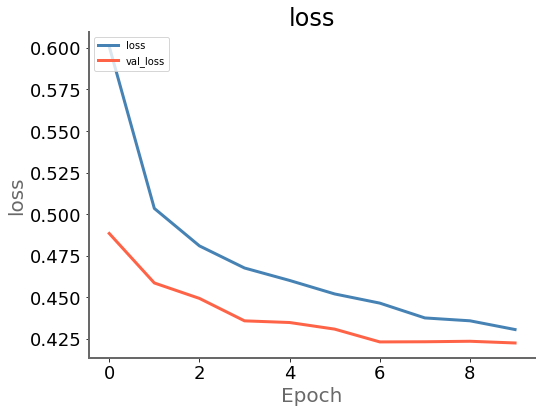

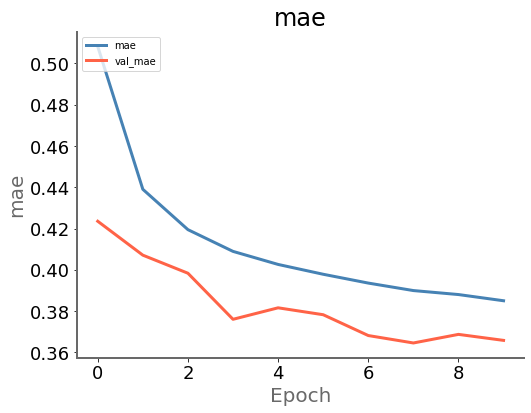

In [10]:
pwk.plot_history(history,plot={'loss':['loss','val_loss'], 'mae':['mae','val_mae']}, save_as='01-history')

## Step 5 - Predict

### 5.1 - Load model

In [11]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')

### 5.2 Make a prediction
A basic prediction, with normalized values (so humanly not very understandable)

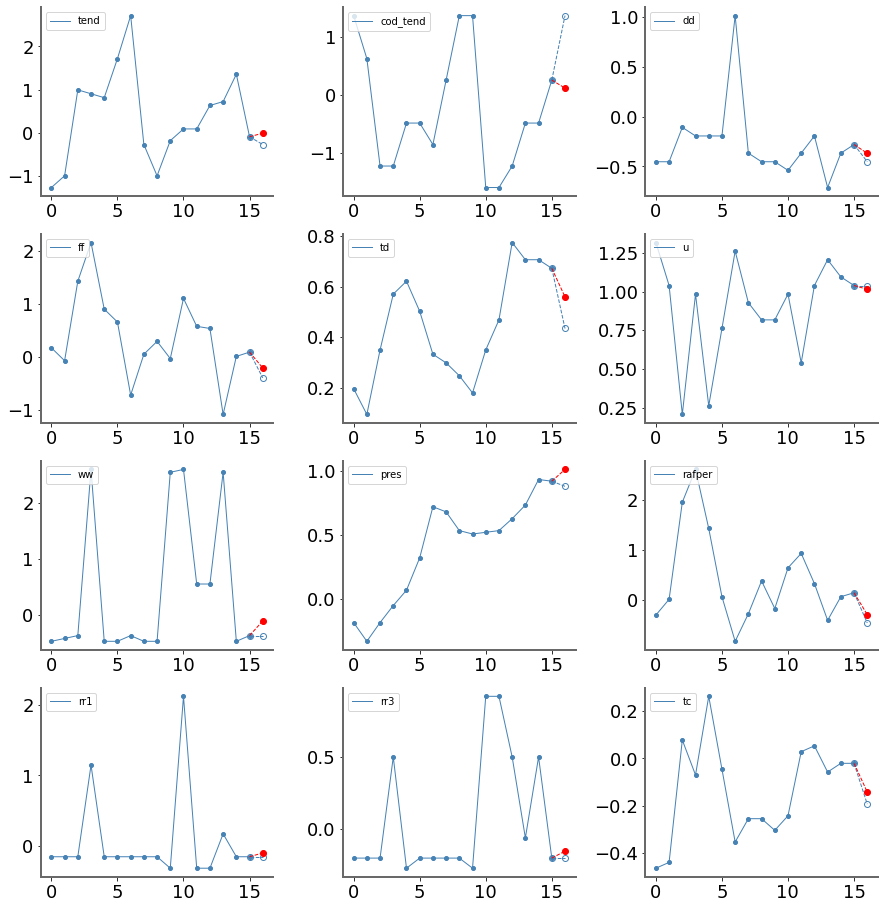

In [12]:
s=random.randint(0,len(dataset_test)-sequence_len)

sequence      = dataset_test[s:s+sequence_len]
sequence_true = dataset_test[s:s+sequence_len+1]

pred = loaded_model.predict( np.array([sequence]) )

# ---- Show result
pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-prediction-norm')


### 5.3 Real prediction
We are now going to make a true prediction, with an un-normalized result

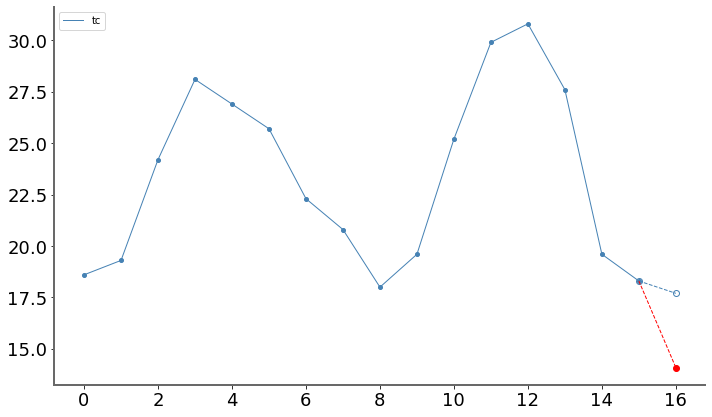

Gap between prediction and reality : 3.61 °C


In [13]:
def denormalize(mean,std,seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq


# ---- Get a sequence

i=random.randint(0,len(dataset_test)-sequence_len)
sequence      = dataset_test[i:i+sequence_len]
sequence_true = dataset_test[i:i+sequence_len+1]

# ---- Prediction

pred = loaded_model.predict( np.array([sequence]) )

# ---- De-normalization

sequence_true = denormalize(mean,std, sequence_true)
pred          = denormalize(mean,std, pred)

# ---- Show it
feat=11

pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, only_features=[feat],width=14, height=8, save_as='03-prediction')

delta_deg=abs(sequence_true[-1][feat]-pred[-1][feat])
print(f'Gap between prediction and reality : {delta_deg:.2f} °C')


In [14]:
pwk.end()

End time is : Tuesday 09 February 2021, 19:55:51
Duration is : 00:02:08 930ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>